In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
pd.options.display.max_columns = None

# Read data

In [2]:
data = pd.read_csv('data/loan_data.csv')

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\162367752.py:1: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/loan_data.csv')


In [3]:
data.shape

(421094, 74)

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,Accounting Clerk,1 year,OWN,65000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,542xx,WI,20.72,0,Sep-00,1,NaN,NaN,25,0,31578,77.0,42,w,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN,0.00,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,52303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
1,60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,Accounts Payable Lead,7 years,MORTGAGE,40000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,235xx,VA,24.57,0,Sep-02,0,36.0,80.0,13,1,5084,38.8,41,w,0.0,0.0,10043.49,10043.49,9942.67,100.81,0.0,0.0,0.0,Oct-15,10059.00,NaN,Jan-16,0,79.0,1,INDIVIDUAL,NaN,NaN,NaN,0,332,175731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
2,60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,Nurse,6 years,MORTGAGE,32000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,350xx,AL,32.41,0,Feb-06,1,NaN,NaN,18,0,12070,74.0,36,f,0.0,0.0,221.96,221.96,167.56,54.40,0.0,0.0,0.0,Oct-15,225.84,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,202012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
3,59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,Service Manager,10+ years,MORTGAGE,48000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,483xx,MI,30.98,0,Oct-99,2,NaN,NaN,18,0,22950,66.0,41,f,0.0,0.0,315.13,315.13,235.76,79.37,0.0,0.0,0.0,Oct-15,327.34,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,108235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
4,58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,NaN,NaN,RENT,32376.0,Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,546xx,WI,32.54,0,Nov-99,3,69.0,NaN,9,0,4172,29.6,26,w,0.0,0.0,333.66,333.66,195.78,137.88,0.0,0.0,0.0,Oct-15,354.87,NaN,Jan-16,0,69.0,1,INDIVIDUAL,NaN,NaN,NaN,0,0,45492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN


In [5]:
data['loan_status'].unique()

array(['Charged Off', 'Current', 'Default', 'Fully Paid',
       'In Grace Period', 'Issued', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

Bộ dữ liệu gồm 75 features với 421094 hàng: mô tả thông tin về các khoản vay
Trường dữ liệu loan_status: chứa thông tin về trạng thái của khoản vay:
    - charge off: không thể thu hồi nợ
    - default: vỡ nợ
    - fully paid: đã trả đầy đủ
    - current: đang thực hiện thanh toán
    - issued: vừa được cấp
    - in grace period: giai đoạn ân hạn (đã qua thời điểm cần phải trả nợ, nhưng chưa quá thời điểm sẽ bị phạt)
    - late (16-30 days): muộn 16-30 ngày
    - late (31-120 days): muộn 31-120 ngày

# Identify the target variable

In [6]:
loan_data = data.copy()
loan_data['target'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                             'Late (31-120 days)',  'Late (16-30 days)']), 0, 1)
loan_data['target'].value_counts(normalize=True)
loan_data.drop(columns = ['loan_status'], inplace = True)

In [7]:
loan_data.shape

(421094, 74)

In [8]:
num_features = loan_data.select_dtypes(include=['int64', 'float64'])
print('The number of numerical features is {}'.format(num_features.shape[1]))

The number of numerical features is 51


In [9]:
num_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,421094.0,5.393094e+07,9.475416e+06,56705.00,4.612481e+07,5.536030e+07,6.186216e+07,6.861706e+07
member_id,421094.0,5.759572e+07,1.013357e+07,70825.00,4.922616e+07,5.895358e+07,6.604582e+07,7.354484e+07
loan_amnt,421094.0,1.524026e+04,8.571314e+03,1000.00,8.500000e+03,1.400000e+04,2.000000e+04,3.500000e+04
funded_amnt,421094.0,1.524026e+04,8.571314e+03,1000.00,8.500000e+03,1.400000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,421094.0,1.523413e+04,8.567923e+03,900.00,8.500000e+03,1.400000e+04,2.000000e+04,3.500000e+04
int_rate,421094.0,1.260173e+01,4.317873e+00,5.32,9.170000e+00,1.229000e+01,1.559000e+01,2.899000e+01
installment,421094.0,4.418727e+02,2.448575e+02,30.12,2.639300e+02,3.854250e+02,5.787900e+02,1.445460e+03
annual_inc,421094.0,7.696561e+04,7.395005e+04,0.00,4.600000e+04,6.500000e+04,9.169125e+04,9.500000e+06
dti,421094.0,1.919601e+01,2.350406e+01,0.00,1.259000e+01,1.860000e+01,2.534000e+01,9.999000e+03
delinq_2yrs,421094.0,3.473975e-01,9.276963e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01


- **id, member_id** xác định mỗi khoản vay, xác định khách hàng: không cần trong quá trình xây dựng mô hình
- **policy_code** có duy nhất 1 giá trị -> không có ý nghĩa

In [10]:
loan_data.drop(['id', 'member_id', 'policy_code', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'], inplace=True, axis=1)
loan_data.shape

(421094, 67)

In [11]:
cat_features = loan_data.select_dtypes(include=['object'])
print('The number of categorical features is {}'.format(cat_features.shape[1]))

The number of categorical features is 22


In [12]:
cat_features.describe().transpose()

,count,unique,top,freq
term,421094,2,36 months,283172
grade,421094,7,C,120567
sub_grade,421094,35,C1,26434
emp_title,397220,120811,Teacher,8070
emp_length,397277,11,10+ years,141520
home_ownership,421094,4,MORTGAGE,207682
verification_status,421094,3,Source Verified,179565
issue_d,421094,12,Oct-15,48631
pymnt_plan,421094,2,n,421093
url,421094,421094,https://www.lendingclub.com/browse/loanDetail....,1


In [13]:
loan_data['application_type'].value_counts(normalize=True)

application_type
INDIVIDUAL    0.998786
JOINT         0.001214
Name: proportion, dtype: float64

In [14]:
loan_data['earliest_cr_line'] 

0         Sep-00
1         Sep-02
2         Feb-06
3         Oct-99
4         Nov-99
           ...  
421089    Oct-99
421090    Jun-06
421091    Aug-06
421092    Jan-90
421093    Oct-03
Name: earliest_cr_line, Length: 421094, dtype: object

**mp_title, url ,desc, title, zip_code, addr_state** có quá nhiều giá trị khác nhau -> xóa
- **desc**: mô tả về khoản vay được cung cấp bởi người vay: tỉ lệ missing quá nhiều, chỉ có 4 bản ghi
- **emp_title** : công việc người vay cung cấp khi đăng ký khoản vay
- **url**: địa chỉ của trang web chứa dữ liệu
- **zip_code**: ba số đầu tiên của mã bưu chính
- **title** là tiêu đề khoản vay
- **addr_state**: tên tỉnh/bang


**pymnt_plan**: kế hoạch trả nợ: có duy nhất 1 giá trị -> xóa

**issue_d, earliest_cr_line, last_pymnt_d, next_pymnt_d,last_credit_pull_d** -> chuyển về định dạng thời gian
- **issue_d** thời gian khoản vay được giải ngân
- **last_credit_pull_d**: thời gian kiểm tra tín dụng gần nhất
- **last_pymnt_d**: thời gian của lần thanh toán khoản vay cuối cùng
- **next_pymnt_d**: ngày thanh toán tiếp theo -> xóa

In [15]:
loan_data.drop(['emp_title', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'pymnt_plan', 'sub_grade', 'next_pymnt_d'], inplace=True, axis=1)
loan_data.shape

(421094, 58)

# Convert Data

In [16]:
# convert column term: object -> numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
loan_term_converter(loan_data, 'term')

In [17]:
loan_data['term']

0         36
1         36
2         36
3         36
4         36
          ..
421089    36
421090    36
421091    60
421092    60
421093    36
Name: term, Length: 421094, dtype: int64

In [18]:
# convert column emp_length values to numeric.
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', '0')
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = df[column].str.replace('\+', '', regex=True)  
    df[column] = pd.to_numeric(df[column])
    
emp_length_converter(loan_data, 'emp_length')
loan_data['emp_length']

0          1.0
1          7.0
2          6.0
3         10.0
4          NaN
          ... 
421089    10.0
421090     3.0
421091     2.0
421092     NaN
421093     3.0
Name: emp_length, Length: 421094, dtype: float64

In [19]:
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')
loan_data['earliest_cr_line']

0        2000-09-01
1        2002-09-01
2        2006-02-01
3        1999-10-01
4        1999-11-01
            ...    
421089   1999-10-01
421090   2006-06-01
421091   2006-08-01
421092   1990-01-01
421093   2003-10-01
Name: earliest_cr_line, Length: 421094, dtype: datetime64[ns]

In [20]:
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y') 
loan_data['last_pymnt_d'] = pd.to_datetime(loan_data['last_pymnt_d'],format='%b-%y')
loan_data['last_credit_pull_d'] = pd.to_datetime(loan_data['last_credit_pull_d'],format='%b-%y')
loan_data[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']].head()

,earliest_cr_line,issue_d,last_pymnt_d,last_credit_pull_d
0,2000-09-01,2015-09-01,NaT,2016-01-01
1,2002-09-01,2015-09-01,2015-10-01,2016-01-01
2,2006-02-01,2015-09-01,2015-10-01,2016-01-01
3,1999-10-01,2015-09-01,2015-10-01,2016-01-01
4,1999-11-01,2015-09-01,2015-10-01,2016-01-01


# Train-test split

In [21]:
X = loan_data.drop('target', axis = 1)
y = loan_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [22]:
X_train.shape, y_train.shape

((336875, 57), (336875,))

In [23]:
y_train.value_counts(normalize=True)

target
1    0.978651
0    0.021349
Name: proportion, dtype: float64

In [24]:
X_test.shape, y_test.shape

((84219, 57), (84219,))

# Pre processing

In [25]:
X_train['earliest_cr_line'].head()

112270   1991-06-01
74514    2011-05-01
33120    1994-07-01
142484   2002-08-01
65418    1987-04-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [26]:
def calculate_month_difference(date_series, reference_date):
    year_diff = reference_date.year - date_series.dt.year
    month_diff = reference_date.month - date_series.dt.month
    
    total_month_diff = year_diff * 12 + month_diff
    
    return total_month_diff


def date_columns(df, column):
    today_date = pd.to_datetime('2020-08-01')
    
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    
    df['mths_since_' + column] = calculate_month_difference(df[column], today_date)

    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    336875.000000
mean        262.388705
std          90.736070
min          93.000000
25%         200.000000
50%         244.000000
75%         310.000000
max         619.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    336875.000000
mean         61.043803
std           3.456198
min          56.000000
25%          58.000000
50%          61.000000
75%          64.000000
max          67.000000
Name: mths_since_issue_d, dtype: float64
count    322963.000000
mean         55.508433
std           1.292713
min          55.000000
25%          55.000000
50%          55.000000
75%          56.000000
max          67.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    336865.000000
mean         55.152595
std           0.898155
min          55.000000
25%          55.000000
50%          55.000000
75%          55.000000
max          68.000000
Name: mths_since_last_credit_pull_d, dtype: float64


In [27]:
# apply to X_test
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')

# let's check these new columns
print(X_test['mths_since_earliest_cr_line'].describe())
print(X_test['mths_since_issue_d'].describe())
print(X_test['mths_since_last_pymnt_d'].describe())
print(X_test['mths_since_last_credit_pull_d'].describe())

count    84219.000000
mean       262.801280
std         91.192772
min         93.000000
25%        200.000000
50%        244.000000
75%        310.000000
max        619.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    84219.000000
mean        61.047935
std          3.466023
min         56.000000
25%         58.000000
50%         61.000000
75%         64.000000
max         67.000000
Name: mths_since_issue_d, dtype: float64
count    80848.000000
mean        55.502882
std          1.276941
min         55.000000
25%         55.000000
50%         55.000000
75%         56.000000
max         67.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    84218.000000
mean        55.147664
std          0.883501
min         55.000000
25%         55.000000
50%         55.000000
75%         55.000000
max         68.000000
Name: mths_since_last_credit_pull_d, dtype: float64


## Handling missing value

In [28]:
# Check missing values
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [29]:
missing_data(X_train)

,Total,Percent
dti_joint,336482,99.883340
annual_inc_joint,336480,99.882746
verification_status_joint,336480,99.882746
il_util,321940,95.566605
mths_since_rcnt_il,320214,95.054249
max_bal_bc,319778,94.924824
total_bal_il,319778,94.924824
open_il_12m,319778,94.924824
open_rv_12m,319778,94.924824
open_rv_24m,319778,94.924824


In [30]:
cols_before = set(X_train.columns)
X_train.dropna(thresh=X_train.shape[0]*0.60, axis=1, inplace=True)
cols_after = set(X_train.columns)
cols_dropped = list(cols_before - cols_after)
X_test.drop(columns=cols_dropped, inplace=True)

In [31]:
# Check missing values
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [32]:
missing_data(X_train)

,Total,Percent
emp_length,19051,5.655213
mths_since_last_pymnt_d,13912,4.129722
revol_util,131,0.038887
mths_since_last_credit_pull_d,10,0.002968
int_rate,0,0.000000
out_prncp,0,0.000000
funded_amnt_inv,0,0.000000
mths_since_issue_d,0,0.000000
mths_since_earliest_cr_line,0,0.000000
total_rev_hi_lim,0,0.000000


In [33]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((336875, 37), (336875,)), ((84219, 37), (84219,)))

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336875 entries, 112270 to 31122
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      336875 non-null  int64  
 1   funded_amnt                    336875 non-null  int64  
 2   funded_amnt_inv                336875 non-null  int64  
 3   term                           336875 non-null  int64  
 4   int_rate                       336875 non-null  float64
 5   installment                    336875 non-null  float64
 6   grade                          336875 non-null  object 
 7   emp_length                     317824 non-null  float64
 8   home_ownership                 336875 non-null  object 
 9   annual_inc                     336875 non-null  float64
 10  verification_status            336875 non-null  object 
 11  purpose                        336875 non-null  object 
 12  dti                            

In [35]:
X_train.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
count,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,317824.000000,3.368750e+05,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,3.368750e+05,336744.000000,336875.000000,336875.00000,336875.00000,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,336875.000000,3.368750e+05,3.368750e+05,336875.000000,336875.000000,322963.000000,336865.000000
mean,15237.201113,15237.201113,15231.038293,43.864235,12.604415,441.809755,6.022881,7.697924e+04,19.203311,0.347847,0.572948,11.948370,0.233303,1.766975e+04,53.835569,25.502269,12819.44625,12814.00224,3150.793922,3149.811973,831.126416,1104.617593,0.020337,0.006082,259.094071,1.398152e+05,3.363467e+04,262.388705,61.043803,55.508433,55.152595
std,8565.111575,8565.111575,8561.701876,11.264805,4.322827,244.656110,3.710073,7.555554e+04,25.908767,0.928933,0.868217,5.635974,0.651985,2.435888e+04,23.901021,12.116366,8371.53164,8367.69902,4234.579990,4233.459209,893.495519,3491.238330,0.157246,0.087013,2289.236256,1.549940e+05,3.844515e+04,90.736070,3.456198,1.292713,0.898155
min,1000.000000,1000.000000,900.000000,36.000000,5.320000,30.120000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,4.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,93.000000,56.000000,55.000000,55.000000
25%,8500.000000,8500.000000,8500.000000,36.000000,9.170000,263.930000,2.000000,4.620000e+04,12.580000,0.000000,0.000000,8.000000,0.000000,6.472000e+03,36.000000,17.000000,6454.30500,6452.19000,856.085000,855.255000,224.840000,256.300000,0.000000,0.000000,0.000000,3.109900e+04,1.430000e+04,200.000000,58.000000,55.000000,55.000000
50%,14000.000000,14000.000000,14000.000000,36.000000,12.290000,385.410000,6.000000,6.500000e+04,18.590000,0.000000,0.000000,11.000000,0.000000,1.198200e+04,54.100000,24.000000,11442.29000,11437.36000,1971.760000,1971.280000,537.490000,392.610000,0.000000,0.000000,0.000000,7.952600e+04,2.460000e+04,244.000000,61.000000,55.000000,55.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,15.590000,578.890000,10.000000,9.180586e+04,25.320000,0.000000,1.000000,15.000000,0.000000,2.141300e+04,72.100000,32.000000,18217.87000,18212.79000,3800.800000,3799.030000,1123.630000,619.930000,0.000000,0.000000,0.000000,2.068365e+05,4.160000e+04,310.000000,64.000000,56.000000,55.000000
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1445.460000,10.000000,9.500000e+06,9999.000000,39.000000,6.000000,90.000000,86.000000,2.904836e+06,184.600000,169.000000,49372.86000,49372.86000,42786.530000,42786.530000,8767.900000,36475.590000,14.000000,14.000000,496651.000000,4.447397e+06,9.999999e+06,619.000000,67.000000,67.000000,68.000000


## Feature Selection


In [36]:
cat_features = X_train.select_dtypes(include=['object'])
print('The number of categorical features is {}'.format(cat_features.shape[1]))

The number of categorical features is 6


In [37]:
# Number of class in object type
cat_features.select_dtypes('object').apply(pd.Series.nunique)

grade                   7
home_ownership          4
verification_status     3
purpose                14
initial_list_status     2
application_type        2
dtype: int64

In [38]:
print(cat_features['application_type'].value_counts(normalize=True))
print(cat_features['initial_list_status'].value_counts(normalize=True))
print(cat_features['home_ownership'].value_counts(normalize=True))
print(cat_features['verification_status'].value_counts(normalize=True))
print(cat_features['grade'].value_counts(normalize=True))
print(cat_features['purpose'].value_counts(normalize=True))

application_type
INDIVIDUAL    0.998827
JOINT         0.001173
Name: proportion, dtype: float64
initial_list_status
w    0.634755
f    0.365245
Name: proportion, dtype: float64
home_ownership
MORTGAGE    0.492791
RENT        0.398498
OWN         0.108705
ANY         0.000006
Name: proportion, dtype: float64
verification_status
Source Verified    0.426295
Verified           0.292031
Not Verified       0.281674
Name: proportion, dtype: float64
grade
C    0.286510
B    0.278813
A    0.174225
D    0.148782
E    0.083010
F    0.023454
G    0.005207
Name: proportion, dtype: float64
purpose
debt_consolidation    0.593466
credit_card           0.242523
home_improvement      0.059895
other                 0.045738
major_purchase        0.017680
medical               0.009419
car                   0.008172
small_business        0.008062
moving                0.005780
vacation              0.005290
house                 0.003417
renewable_energy      0.000549
wedding               0.000006
educat

### Chi-squared statistic for categorical features

In [39]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in cat_features:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, cat_features[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,initial_list_status,0.000000
5,application_type,0.038788


### ANOVA F-Statistic for numerical features

In [40]:
X_train_num = X_train.select_dtypes(include = 'number').copy()

# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table


,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,43803.892052,0.000000e+00
1,mths_since_issue_d,4934.006963,0.000000e+00
2,int_rate,4867.261681,0.000000e+00
3,out_prncp,999.326059,0.000000e+00
4,out_prncp_inv,999.244445,0.000000e+00
5,inq_last_6mths,484.625342,0.000000e+00
6,mths_since_last_credit_pull_d,351.866248,0.000000e+00
7,total_rec_int,274.536262,0.000000e+00
8,last_pymnt_amnt,227.639408,0.000000e+00
9,term,207.715004,0.000000e+00


Text(0.5, 1.0, 'Pearson correlation')

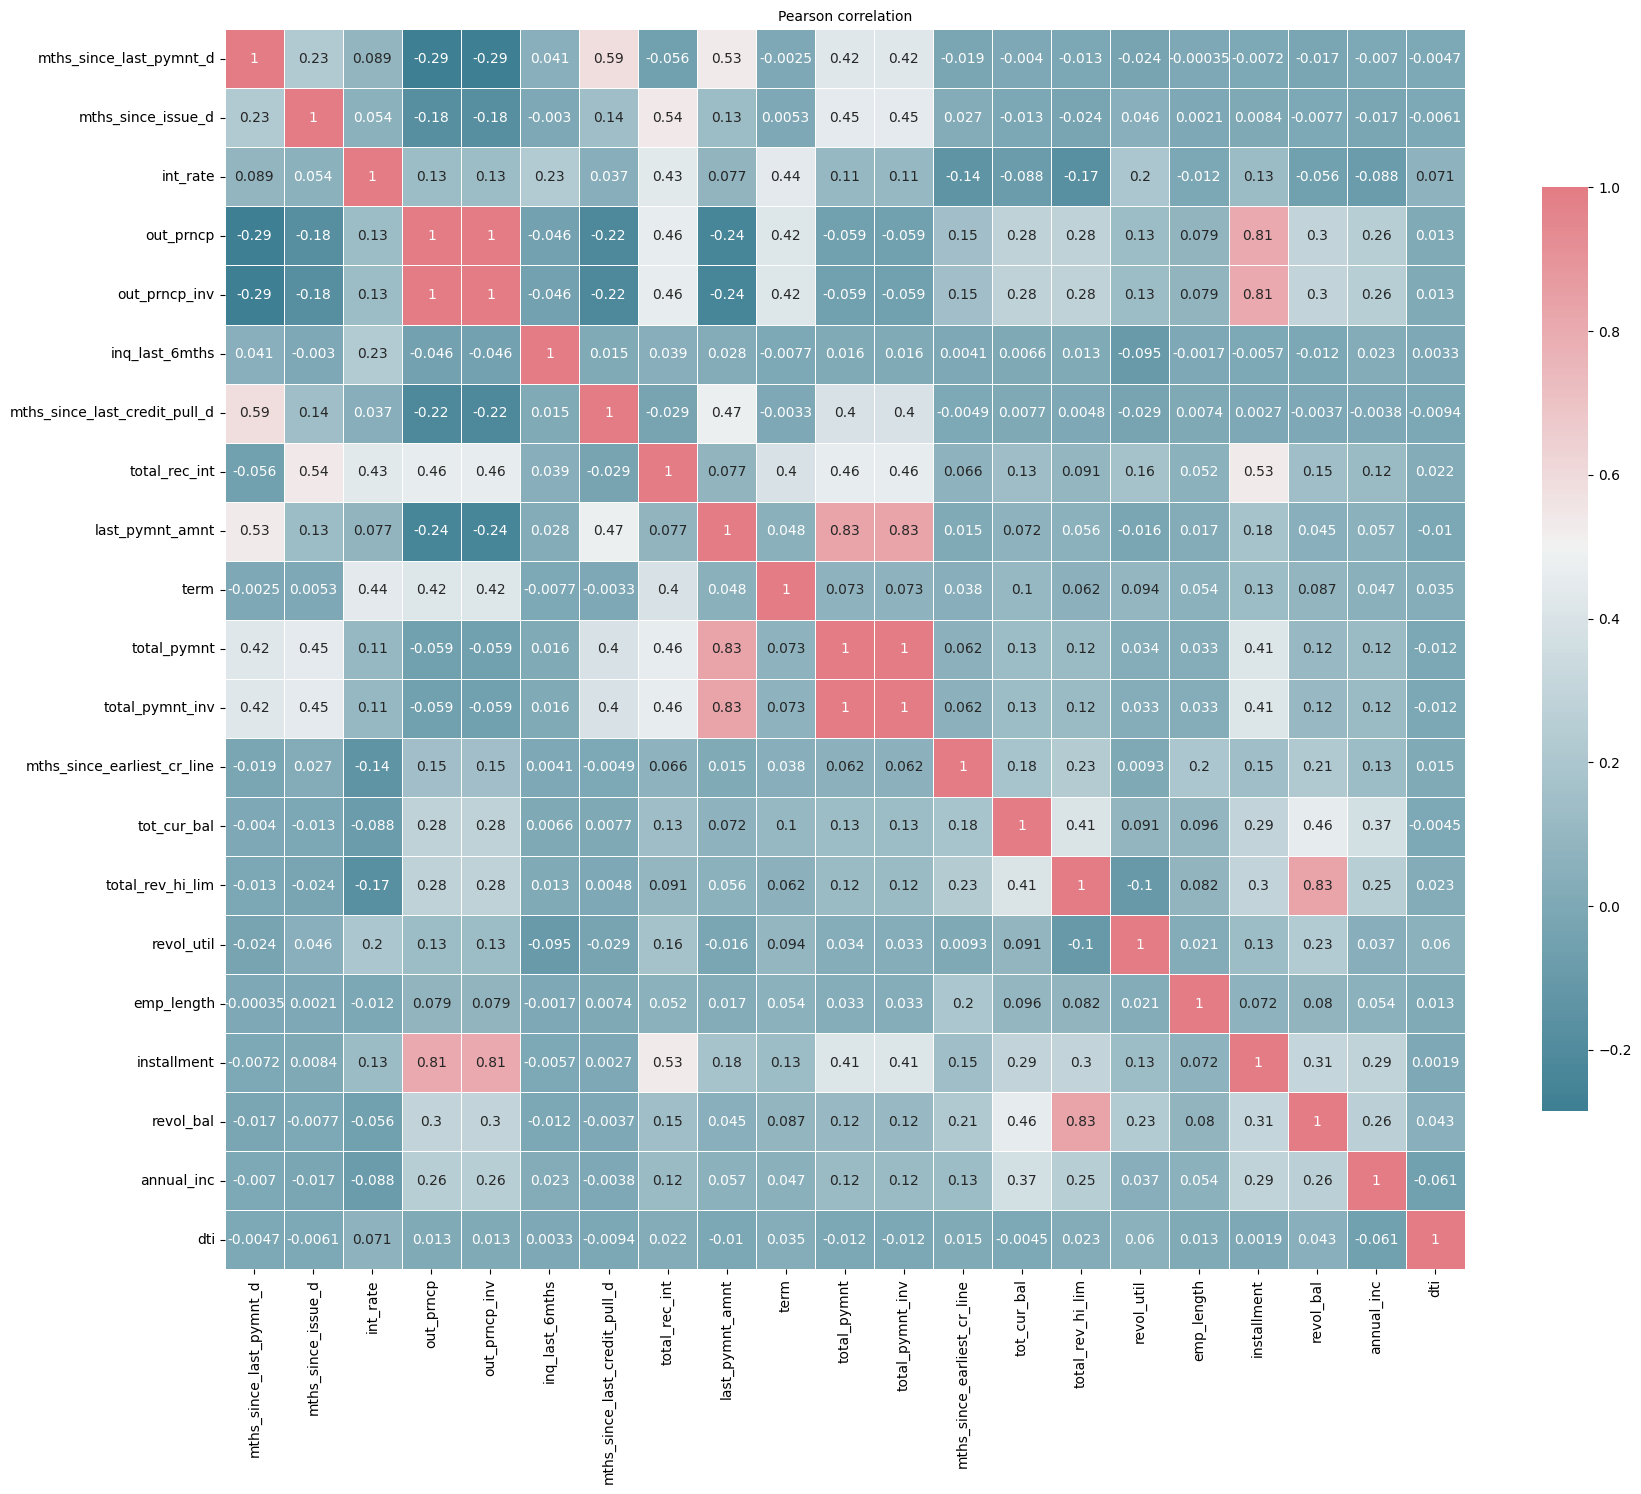

In [41]:
# save the top 21 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:21,0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrmat, cmap= cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

plt.title("Pearson correlation", fontsize =10)

In [42]:
drop_columns_list = ANOVA_F_table.iloc[21:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv', 'installment', 'revol_bal'])


def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

In [43]:
col_to_drop(X_test, drop_columns_list)

In [44]:
(X_train.shape, X_test.shape)

((336875, 21), (84219, 21))

In [45]:
X_train.columns

Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'inq_last_6mths',
       'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype='object')

In [46]:
X_train_pre = X_train.copy()

## Creating Dummy Variables

In [47]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [48]:
X_train.columns

Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'inq_last_6mths',
       'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d', 'grade:A',
       'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G',
       'home_ownership:ANY', 'home_ownership:MORTGAGE', 'home_ownership:OWN',
       'home_ownership:RENT', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'verification_status:Verified',
       'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:educational', 'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy', 'purpose:small_busin

In [49]:
X_train.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
112270,60,7.89,A,0.0,RENT,135000.0,Verified,credit_card,24.75,1,85.0,26845.94,1668.13,514.07,566.27,238610,45300,350,58,55.0,55.0,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
74514,36,11.53,B,2.0,RENT,145000.0,Source Verified,other,10.16,1,14.5,5718.05,388.21,106.26,197.95,44216,20500,111,58,55.0,55.0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
33120,36,9.17,B,6.0,RENT,52000.0,Verified,debt_consolidation,20.02,1,53.6,9367.33,328.04,95.37,337.82,24566,11500,313,56,55.0,55.0,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
142484,36,6.24,A,5.0,MORTGAGE,56000.0,Not Verified,car,5.25,0,2.8,3264.67,1009.28,73.95,128.23,152110,17900,216,59,55.0,55.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
65418,36,8.18,B,10.0,OWN,120000.0,Source Verified,debt_consolidation,14.44,0,83.4,19986.91,1302.09,264.00,660.60,242624,58300,400,57,55.0,55.0,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [50]:
X_test.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
256888,36,18.25,E,2.0,RENT,42000.0,Verified,debt_consolidation,38.03,0,86.4,6701.42,2033.83,810.25,287.51,32991,20800,260,63,55.0,55.0
64807,36,10.99,B,6.0,RENT,49920.0,Verified,debt_consolidation,31.81,0,60.9,11431.59,770.97,202.56,392.81,58690,54700,230,57,55.0,55.0
38259,36,9.99,B,3.0,RENT,70000.0,Verified,car,18.40,3,47.1,2928.18,95.13,23.32,96.79,57648,23700,318,57,55.0,55.0
84320,36,9.99,B,10.0,MORTGAGE,110000.0,Verified,car,8.43,0,65.2,3046.16,204.70,50.86,103.24,238411,43100,330,58,56.0,55.0
86544,36,9.17,B,2.0,MORTGAGE,70000.0,Verified,credit_card,1.75,0,20.0,19026.80,1264.97,291.77,637.58,131024,18300,103,58,56.0,55.0


In [51]:
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])

# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [52]:
labels=X_train.columns

In [53]:
X_test.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
256888,36,18.25,E,2.0,RENT,42000.0,Verified,debt_consolidation,38.03,0,86.4,6701.42,2033.83,810.25,287.51,32991,20800,260,63,55.0,55.0,False,False,False,False,True,False,False,0,False,False,True,False,False,True,False,False,True,0,False,False,False,False,False,False,False,False,False,False
64807,36,10.99,B,6.0,RENT,49920.0,Verified,debt_consolidation,31.81,0,60.9,11431.59,770.97,202.56,392.81,58690,54700,230,57,55.0,55.0,False,True,False,False,False,False,False,0,False,False,True,False,False,True,False,False,True,0,False,False,False,False,False,False,False,False,False,False
38259,36,9.99,B,3.0,RENT,70000.0,Verified,car,18.40,3,47.1,2928.18,95.13,23.32,96.79,57648,23700,318,57,55.0,55.0,False,True,False,False,False,False,False,0,False,False,True,False,False,True,True,False,False,0,False,False,False,False,False,False,False,False,False,False
84320,36,9.99,B,10.0,MORTGAGE,110000.0,Verified,car,8.43,0,65.2,3046.16,204.70,50.86,103.24,238411,43100,330,58,56.0,55.0,False,True,False,False,False,False,False,0,True,False,False,False,False,True,True,False,False,0,False,False,False,False,False,False,False,False,False,False
86544,36,9.17,B,2.0,MORTGAGE,70000.0,Verified,credit_card,1.75,0,20.0,19026.80,1264.97,291.77,637.58,131024,18300,103,58,56.0,55.0,False,True,False,False,False,False,False,0,True,False,False,False,False,True,False,True,False,0,False,False,False,False,False,False,False,False,False,False


## WoE Binning/Feature Engineering

In [54]:
ref_categories = ['grade:G',  'home_ownership:MORTGAGE', 'verification_status:Not Verified', 'purpose:major_purch__car__home_impr', 'term:60', 'int_rate:>20.281', 
                  'annual_inc:>150K', 'dti:>35.191', 'inq_last_6mths:>4',  'revol_util:>1.0', 'out_prncp:>15,437', 'total_pymnt:>25,000', 'total_rec_int:>7,260', 
                  'total_rev_hi_lim:>79,780', 'mths_since_earliest_cr_line:>434',  'mths_since_issue_d:>122', 'mths_since_last_credit_pull_d:>75',]

In [55]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

### Analyze WoEs and IVs of discrete features

In [56]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [57]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

#### grade

In [58]:
df_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,1754,0.889966,0.005207,1561.0,193.0,0.004735,0.026835,-1.734771,NaN,NaN,0.613689
1,F,7901,0.922668,0.023454,7290.0,611.0,0.022112,0.084956,-1.346000,0.032702,0.388770,0.613689
2,E,27964,0.950615,0.083010,26583.0,1381.0,0.080632,0.192019,-0.867698,0.027947,0.478302,0.613689
3,D,50121,0.963349,0.148782,48284.0,1837.0,0.146456,0.255423,-0.556196,0.012734,0.311502,0.613689
4,C,96518,0.979786,0.286510,94567.0,1951.0,0.286842,0.271274,0.055804,0.016437,0.612000,0.613689
5,B,93925,0.989854,0.278813,92972.0,953.0,0.282004,0.132508,0.755276,0.010067,0.699472,0.613689
6,A,58692,0.995468,0.174225,58426.0,266.0,0.177219,0.036986,1.566858,0.005614,0.811581,0.613689


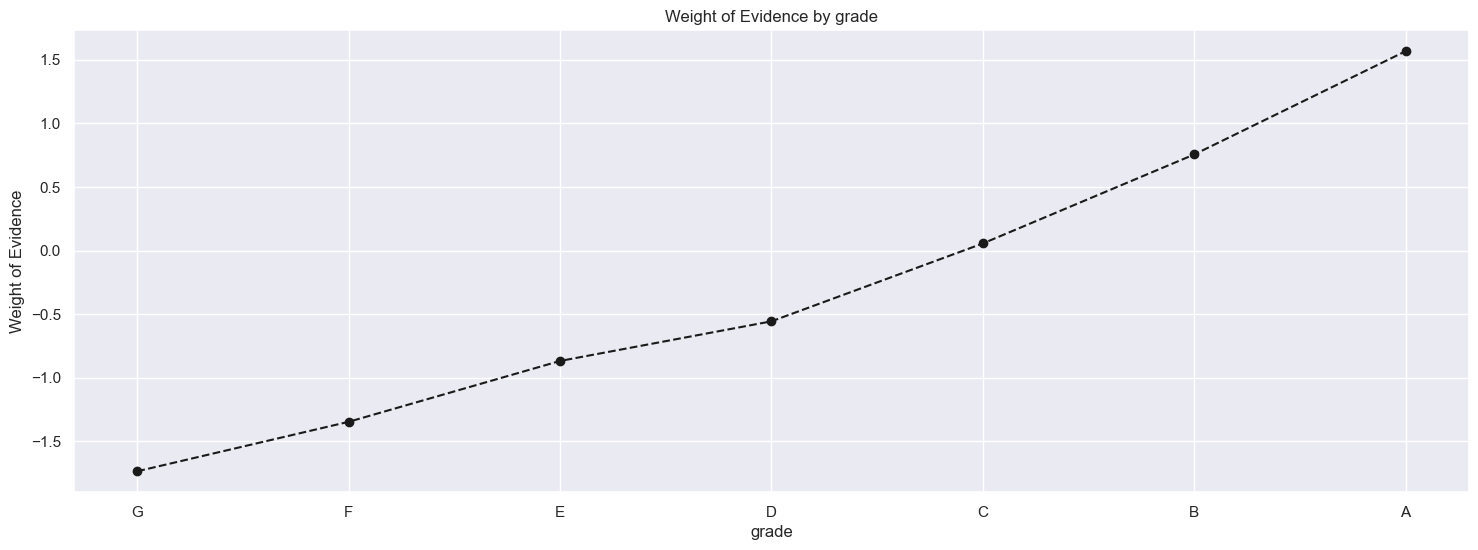

In [59]:
plot_by_woe(df_temp)

#### home_ownership

In [60]:
df_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,134244,0.973921,0.398498,130743.0,3501.0,0.396572,0.486791,-0.204977,NaN,NaN,inf
1,OWN,36620,0.977581,0.108705,35799.0,821.0,0.108586,0.114155,-0.050010,0.003660,0.154967,inf
2,MORTGAGE,166009,0.982712,0.492791,163139.0,2870.0,0.494836,0.399055,0.215128,0.005131,0.265138,inf
3,ANY,2,1.000000,0.000006,2.0,0.0,0.000006,0.000000,inf,0.017288,inf,inf


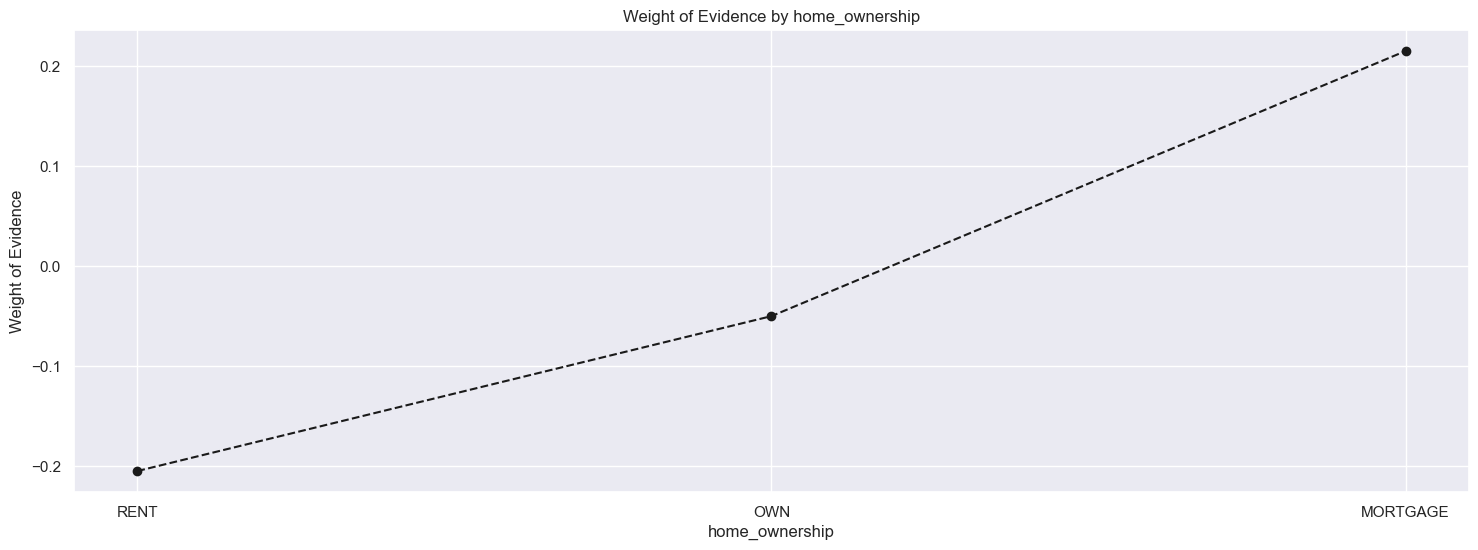

In [61]:
plot_by_woe(df_temp)

#### verification_status

In [62]:
df_temp = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,98378,0.973205,0.292031,95742.0,2636.0,0.290406,0.366518,-0.232768,NaN,NaN,0.050422
1,Source Verified,143608,0.978086,0.426295,140461.0,3147.0,0.426049,0.437570,-0.026682,0.004881,0.206086,0.050422
2,Not Verified,94889,0.985151,0.281674,93480.0,1409.0,0.283545,0.195912,0.369705,0.007065,0.396387,0.050422


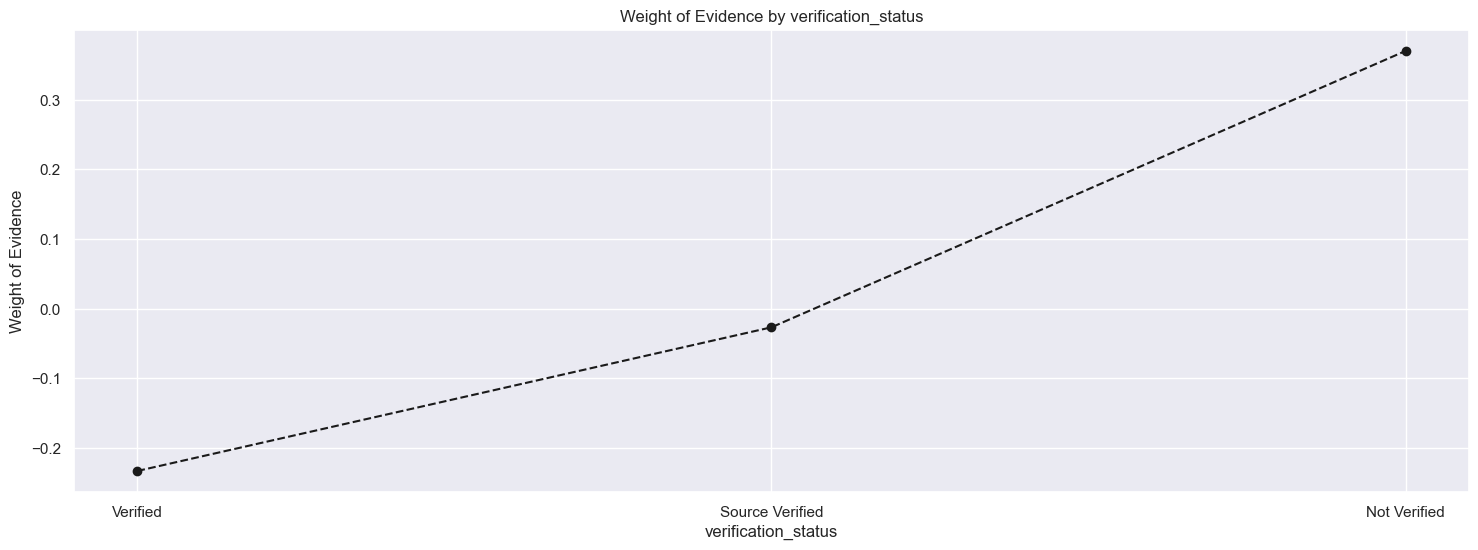

In [63]:
plot_by_woe(df_temp)

#### purpose

In [64]:
df_temp = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,wedding,2,0.500000,0.000006,1.0,1.0,0.000003,0.000139,-3.825162,NaN,NaN,inf
1,small_business,2716,0.955081,0.008062,2594.0,122.0,0.007868,0.016963,-0.768227,0.455081,3.056935,inf
2,moving,1947,0.955829,0.005780,1861.0,86.0,0.005645,0.011958,-0.750640,0.000748,0.017587,inf
3,house,1151,0.961772,0.003417,1107.0,44.0,0.003358,0.006118,-0.599943,0.005943,0.150697,inf
4,renewable_energy,185,0.967568,0.000549,179.0,6.0,0.000543,0.000834,-0.429536,0.005795,0.170407,inf
5,medical,3173,0.968799,0.009419,3074.0,99.0,0.009324,0.013765,-0.389547,0.001232,0.039989,inf
6,vacation,1782,0.972503,0.005290,1733.0,49.0,0.005257,0.006813,-0.259373,0.003704,0.130174,inf
7,major_purchase,5956,0.973472,0.017680,5798.0,158.0,0.017587,0.021969,-0.222489,0.000969,0.036884,inf
8,other,15408,0.973585,0.045738,15001.0,407.0,0.045501,0.056591,-0.218103,0.000113,0.004386,inf
9,debt_consolidation,199924,0.976846,0.593466,195295.0,4629.0,0.592372,0.643632,-0.082992,0.003261,0.135111,inf


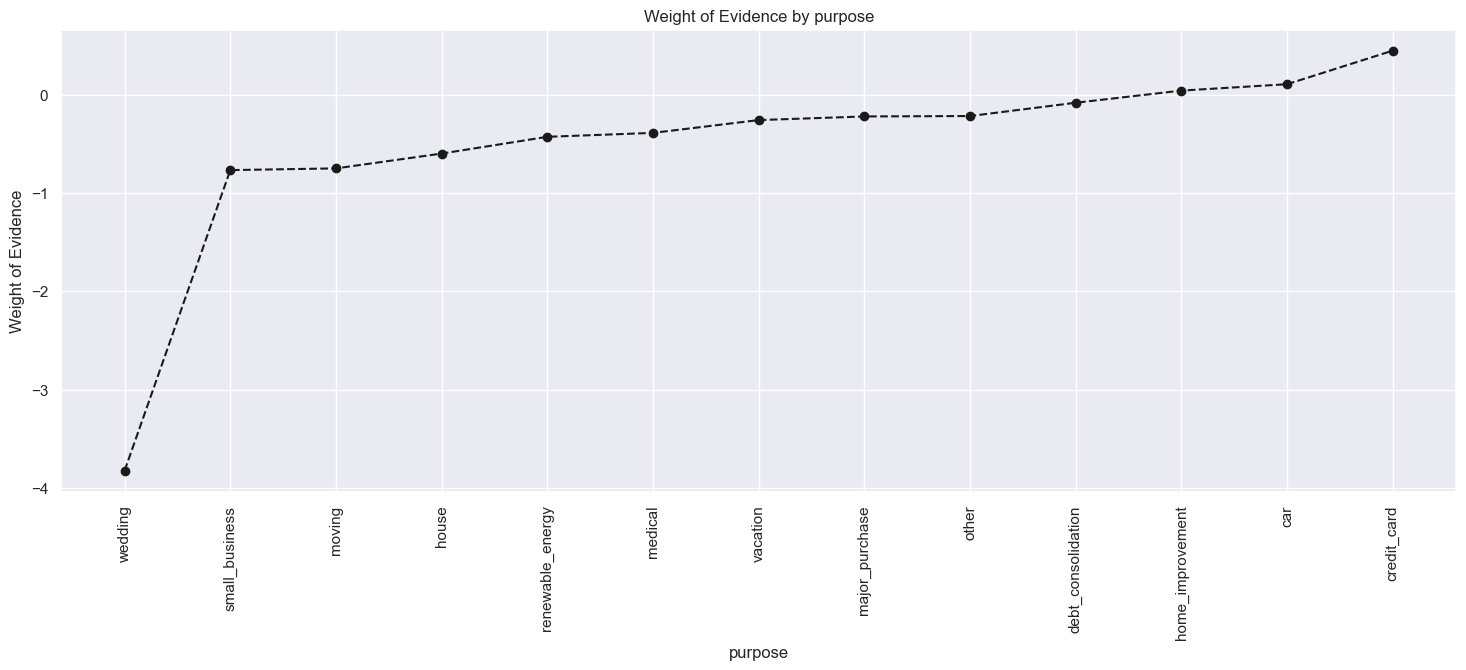

In [65]:
plot_by_woe(df_temp, 90)

### Analyze WoEs and IVs of numeric features

In [66]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [67]:
X_train.describe()

,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
count,336875.000000,336875.000000,317824.000000,3.368750e+05,336875.000000,336875.000000,336744.000000,336875.00000,336875.000000,336875.000000,336875.000000,3.368750e+05,3.368750e+05,336875.000000,336875.000000,322963.000000,336865.000000
mean,43.864235,12.604415,6.022881,7.697924e+04,19.203311,0.572948,53.835569,12819.44625,3150.793922,831.126416,1104.617593,1.398152e+05,3.363467e+04,262.388705,61.043803,55.508433,55.152595
std,11.264805,4.322827,3.710073,7.555554e+04,25.908767,0.868217,23.901021,8371.53164,4234.579990,893.495519,3491.238330,1.549940e+05,3.844515e+04,90.736070,3.456198,1.292713,0.898155
min,36.000000,5.320000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,93.000000,56.000000,55.000000,55.000000
25%,36.000000,9.170000,2.000000,4.620000e+04,12.580000,0.000000,36.000000,6454.30500,856.085000,224.840000,256.300000,3.109900e+04,1.430000e+04,200.000000,58.000000,55.000000,55.000000
50%,36.000000,12.290000,6.000000,6.500000e+04,18.590000,0.000000,54.100000,11442.29000,1971.760000,537.490000,392.610000,7.952600e+04,2.460000e+04,244.000000,61.000000,55.000000,55.000000
75%,60.000000,15.590000,10.000000,9.180586e+04,25.320000,1.000000,72.100000,18217.87000,3800.800000,1123.630000,619.930000,2.068365e+05,4.160000e+04,310.000000,64.000000,56.000000,55.000000
max,60.000000,28.990000,10.000000,9.500000e+06,9999.000000,6.000000,184.600000,49372.86000,42786.530000,8767.900000,36475.590000,4.447397e+06,9.999999e+06,619.000000,67.000000,67.000000,68.000000


#### term

In [68]:
df_temp = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,226489,0.981156,0.672324,222221.0,4268.0,0.674044,0.593437,0.127365,NaN,NaN,0.028079
1,60,110386,0.973511,0.327676,107462.0,2924.0,0.325956,0.406563,-0.220978,0.007645,0.348342,0.028079


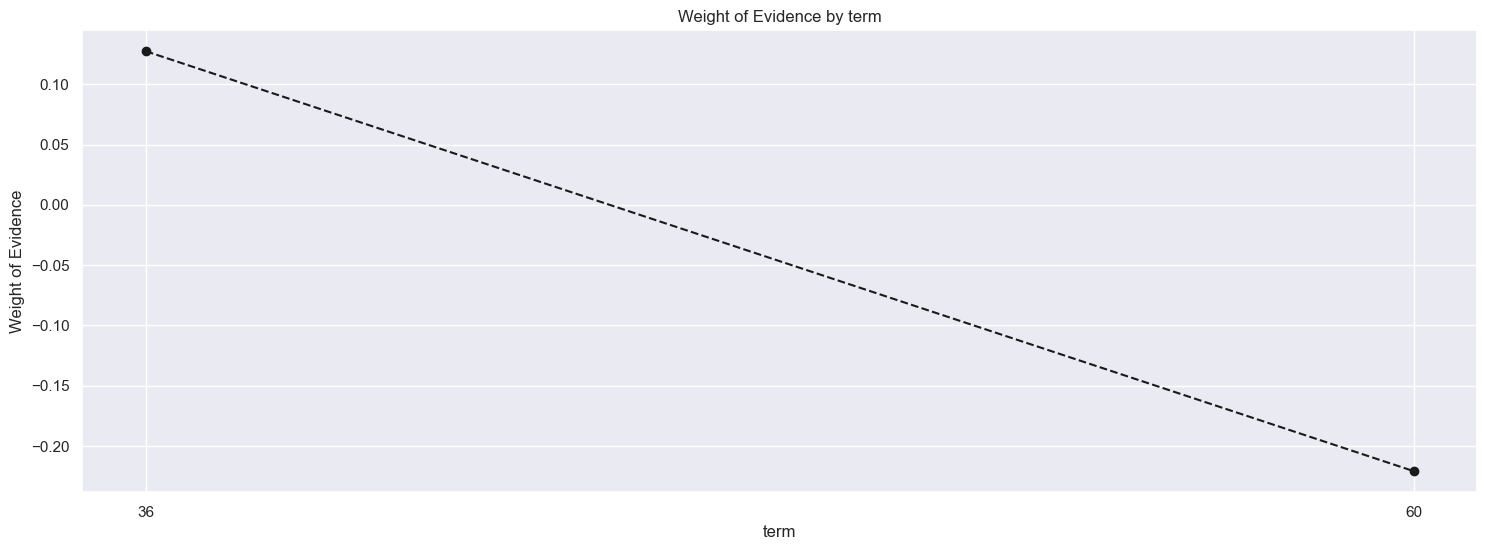

In [69]:
plot_by_woe(df_temp)

không sử dụng term trong quá trình xây dựng mô hình:

- IV thấp: Đặc trưng không cung cấp đủ thông tin để đóng góp vào mô hình dự đoán.
- Phạm vi WoE nhỏ: Đặc trưng không có khả năng phân biệt rõ ràng giữa các khoản vay tốt và xấu.

#### int_rate

In [70]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 50)

# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.296, 5.793]",7807,0.998975,0.023175,7799.0,8.0,0.023656,0.001112,3.057147,NaN,NaN,inf
1,"(5.793, 6.267]",8217,0.996714,0.024392,8190.0,27.0,0.024842,0.003754,1.889670,0.002261,1.167477,inf
2,"(6.267, 6.74]",5236,0.993125,0.015543,5200.0,36.0,0.015773,0.005006,1.147733,0.003590,0.741937,inf
3,"(6.74, 7.214]",9986,0.994292,0.029643,9929.0,57.0,0.030117,0.007925,1.335001,0.001167,0.187269,inf
4,"(7.214, 7.687]",9033,0.997122,0.026814,9007.0,26.0,0.027320,0.003615,2.022499,0.002830,0.687497,inf
5,"(7.687, 8.16]",16504,0.995153,0.048991,16424.0,80.0,0.049818,0.011123,1.499310,0.001969,0.523188,inf
6,"(8.16, 8.634]",17990,0.992829,0.053403,17861.0,129.0,0.054176,0.017937,1.105400,0.002323,0.393910,inf
7,"(8.634, 9.107]",1578,0.979087,0.004684,1545.0,33.0,0.004686,0.004588,0.021109,0.013742,1.084291,inf
8,"(9.107, 9.581]",17770,0.992122,0.052750,17630.0,140.0,0.053476,0.019466,1.010553,0.013034,0.989443,inf
9,"(9.581, 10.054]",17826,0.992707,0.052916,17696.0,130.0,0.053676,0.018076,1.088397,0.000586,0.077845,inf


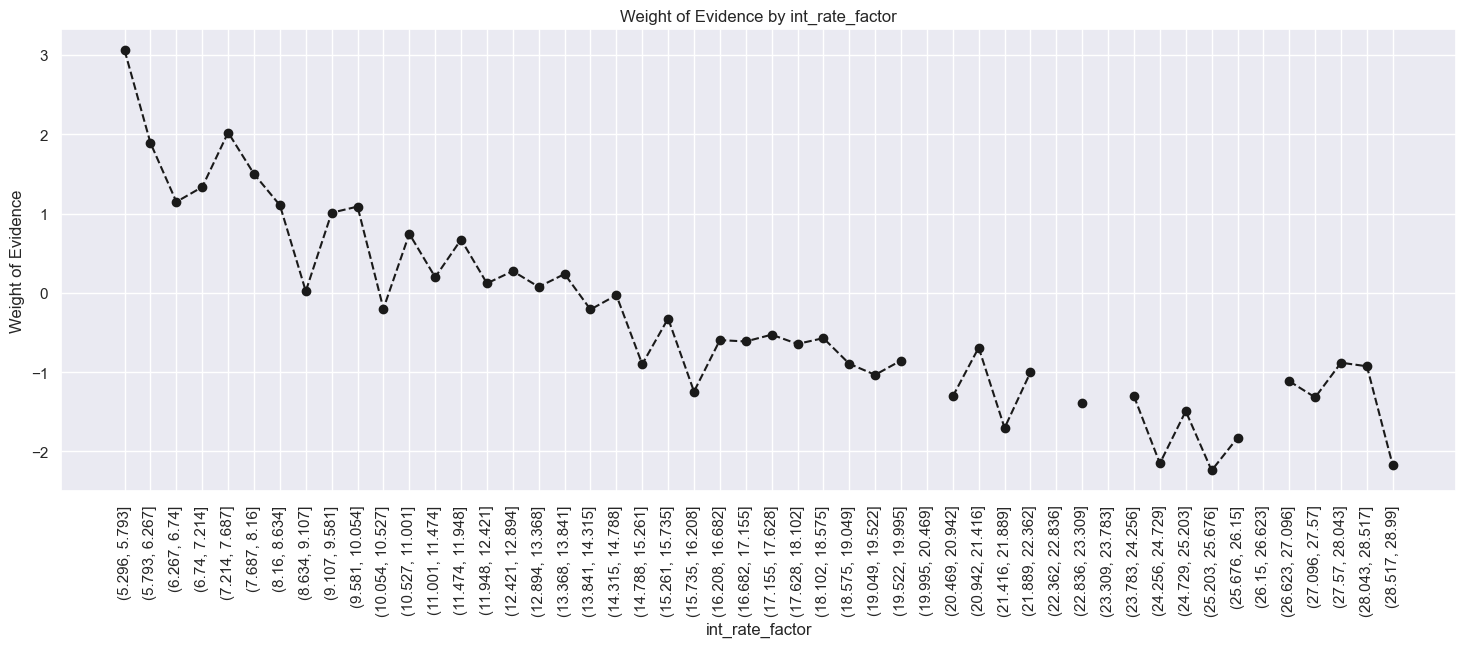

In [71]:
plot_by_woe(df_temp, 90)

#### emp_length

In [72]:
df_temp = woe_ordered_continuous(X_train_prepr, 'emp_length', y_train_prepr)
df_temp

,emp_length,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,27516,0.975505,0.086576,26842.0,674.0,0.086277,0.100462,-0.152220,NaN,NaN,0.014836
1,1.0,21987,0.974985,0.069180,21437.0,550.0,0.068904,0.081979,-0.173757,0.000520,0.021538,0.014836
2,2.0,30086,0.978196,0.094662,29430.0,656.0,0.094595,0.097779,-0.033104,0.003211,0.140654,0.014836
3,3.0,26672,0.977654,0.083921,26076.0,596.0,0.083815,0.088836,-0.058183,0.000541,0.025079,0.014836
4,4.0,19701,0.976448,0.061987,19237.0,464.0,0.061832,0.069161,-0.112006,0.001207,0.053824,0.014836
5,5.0,19884,0.977972,0.062563,19446.0,438.0,0.062504,0.065285,-0.043535,0.001524,0.068472,0.014836
6,6.0,13503,0.977190,0.042486,13195.0,308.0,0.042412,0.045908,-0.079219,0.000782,0.035684,0.014836
7,7.0,14681,0.975887,0.046192,14327.0,354.0,0.046050,0.052765,-0.136108,0.001303,0.056889,0.014836
8,8.0,17247,0.981156,0.054266,16922.0,325.0,0.054391,0.048442,0.115832,0.005269,0.251940,0.014836
9,9.0,13414,0.979424,0.042206,13138.0,276.0,0.042229,0.041139,0.026150,0.001732,0.089681,0.014836


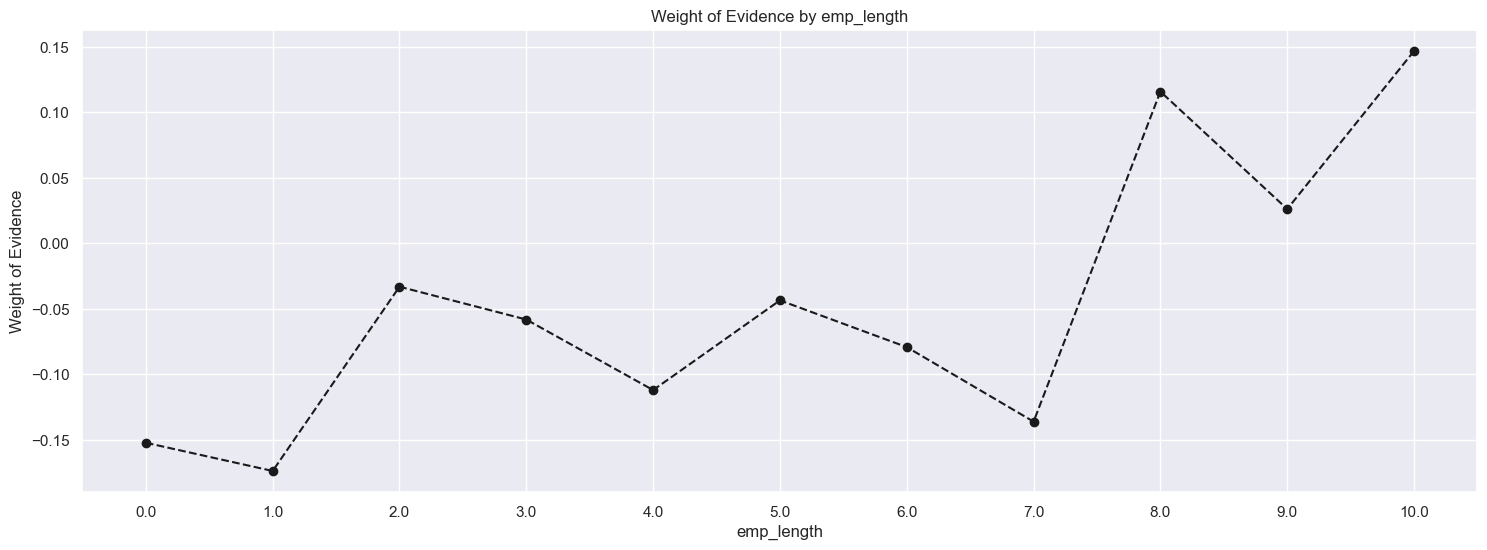

In [73]:
plot_by_woe(df_temp)

<!-- không sử dụng term trong quá trình xây dựng mô hình:

- IV thấp: Đặc trưng không cung cấp đủ thông tin để đóng góp vào mô hình dự đoán.
- Phạm vi WoE nhỏ: Đặc trưng không có khả năng phân biệt rõ ràng giữa các khoản vay tốt và xấu. -->

#### annual_inc

In [74]:
# fine-classing
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9500.0, 190000.0]",327830,0.978529,0.973150,320791.0,7039.0,0.973029,0.978726,-0.005839,NaN,NaN,inf
1,"(190000.0, 380000.0]",7944,0.982251,0.023581,7803.0,141.0,0.023668,0.019605,0.188341,0.003722,0.194180,inf
2,"(380000.0, 570000.0]",733,0.986357,0.002176,723.0,10.0,0.002193,0.001390,0.455662,0.004107,0.267320,inf
3,"(570000.0, 760000.0]",211,0.995261,0.000626,210.0,1.0,0.000637,0.000139,1.521945,0.008903,1.066283,inf
4,"(760000.0, 950000.0]",60,1.000000,0.000178,60.0,0.0,0.000182,0.000000,inf,0.004739,inf,inf
5,"(950000.0, 1140000.0]",36,1.000000,0.000107,36.0,0.0,0.000109,0.000000,inf,0.000000,NaN,inf
6,"(1140000.0, 1330000.0]",13,1.000000,0.000039,13.0,0.0,0.000039,0.000000,inf,0.000000,NaN,inf
7,"(1330000.0, 1520000.0]",10,1.000000,0.000030,10.0,0.0,0.000030,0.000000,inf,0.000000,NaN,inf
8,"(1520000.0, 1710000.0]",2,1.000000,0.000006,2.0,0.0,0.000006,0.000000,inf,0.000000,NaN,inf
9,"(1710000.0, 1900000.0]",3,1.000000,0.000009,3.0,0.0,0.000009,0.000000,inf,0.000000,NaN,inf


In [75]:
# Initial examination shows that there are too few individuals with large income (up to $75m!!) and too many with small income.
# Since 95.6% of observations have income < 151,858, we will have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
X_train_prepr_temp = X_train_prepr[X_train_prepr['annual_inc'] <= 150000].copy()

# fine-classing again
X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 50)

# make sure to select only the relevant indexes in the target column
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'annual_inc_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-150.0, 3000.0]",5,1.000000,0.000016,5.0,0.0,0.000016,0.000000,inf,NaN,NaN,inf
1,"(3000.0, 6000.0]",13,0.923077,0.000041,12.0,1.0,0.000038,0.000145,-1.328837,0.076923,inf,inf
2,"(6000.0, 9000.0]",87,1.000000,0.000273,87.0,0.0,0.000279,0.000000,inf,0.076923,inf,inf
3,"(9000.0, 12000.0]",521,0.969290,0.001634,505.0,16.0,0.001619,0.002325,-0.361774,0.030710,inf,inf
4,"(12000.0, 15000.0]",944,0.974576,0.002961,920.0,24.0,0.002949,0.003487,-0.167424,0.005286,0.194350,inf
5,"(15000.0, 18000.0]",1369,0.972973,0.004294,1332.0,37.0,0.004270,0.005376,-0.230224,0.001603,0.062801,inf
6,"(18000.0, 21000.0]",2520,0.967857,0.007904,2439.0,81.0,0.007819,0.011768,-0.408849,0.005116,0.178625,inf
7,"(21000.0, 24000.0]",3522,0.972459,0.011047,3425.0,97.0,0.010980,0.014093,-0.249598,0.004602,0.159252,inf
8,"(24000.0, 27000.0]",5427,0.971255,0.017022,5271.0,156.0,0.016898,0.022665,-0.293624,0.001204,0.044026,inf
9,"(27000.0, 30000.0]",8838,0.970355,0.027721,8576.0,262.0,0.027493,0.038065,-0.325365,0.000900,0.031741,inf


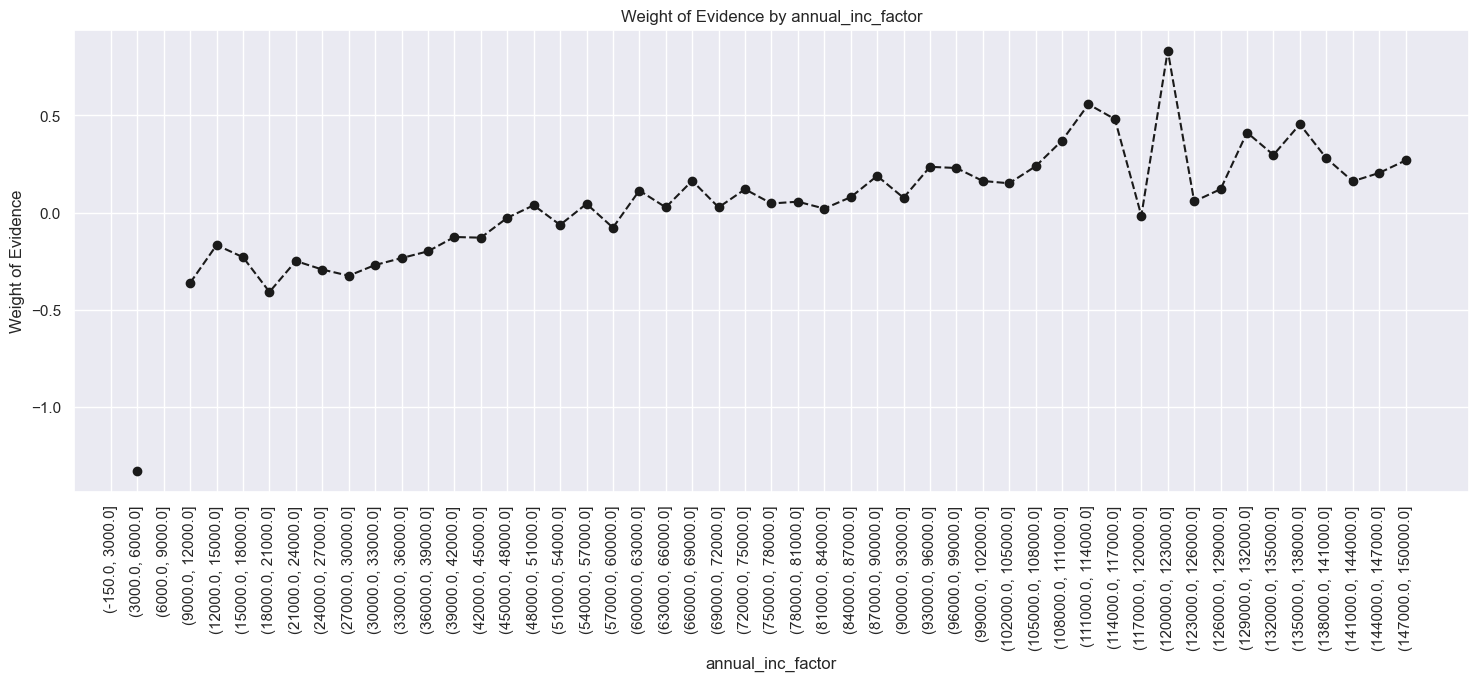

In [76]:
plot_by_woe(df_temp, 90)

#### dti

In [77]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['dti'] <= 42].copy()
# fine-classing

X_train_prepr_temp['dti_factor'] = pd.cut(X_train_prepr_temp['dti'], 50)
# Process 'annual_inc_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'dti_factor', y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.0419, 0.839]",716,0.969274,0.002126,694.0,22.0,0.002105,0.003059,-0.373557,NaN,NaN,inf
1,"(0.839, 1.678]",1161,0.983635,0.003447,1142.0,19.0,0.003465,0.002642,0.271111,0.014361,0.644668,inf
2,"(1.678, 2.516]",1757,0.980080,0.005216,1722.0,35.0,0.005224,0.004867,0.070907,0.003555,0.200204,inf
3,"(2.516, 3.355]",2528,0.976266,0.007506,2468.0,60.0,0.007487,0.008343,-0.108168,0.003814,0.179075,inf
4,"(3.355, 4.194]",3277,0.983216,0.009729,3222.0,55.0,0.009775,0.007647,0.245438,0.006951,0.353606,inf
5,"(4.194, 5.033]",3870,0.985013,0.011490,3812.0,58.0,0.011565,0.008065,0.360480,0.001797,0.115042,inf
6,"(5.033, 5.872]",4915,0.985758,0.014592,4845.0,70.0,0.014699,0.009733,0.412221,0.000745,0.051741,inf
7,"(5.872, 6.71]",5528,0.983357,0.016412,5436.0,92.0,0.016491,0.012792,0.254024,0.002400,0.158197,inf
8,"(6.71, 7.549]",6248,0.984475,0.018550,6151.0,97.0,0.018661,0.013487,0.324673,0.001118,0.070649,inf
9,"(7.549, 8.388]",7204,0.980983,0.021388,7067.0,137.0,0.021440,0.019049,0.118224,0.003492,0.206449,inf


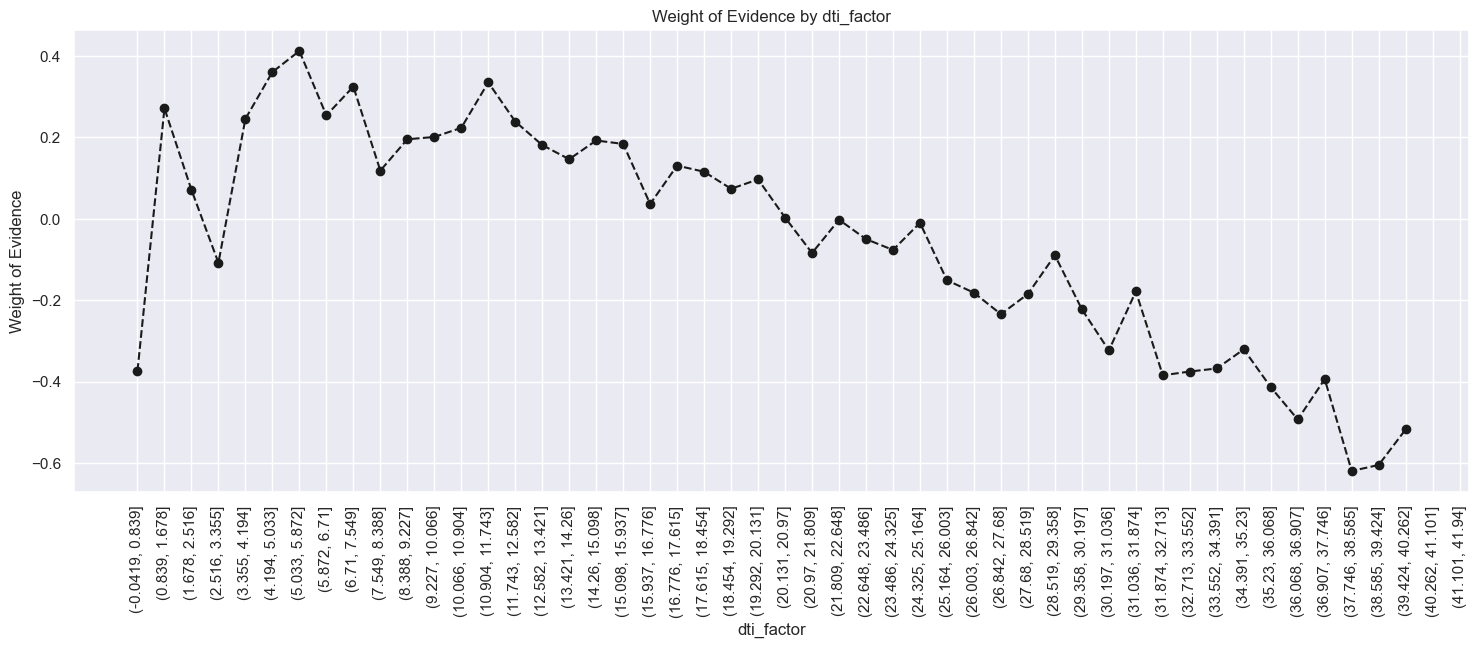

In [78]:
plot_by_woe(df_temp, 90)

#### inq_last_6mths

In [79]:
df_temp = woe_ordered_continuous(X_train_prepr, 'inq_last_6mths', y_train_prepr)
df_temp

,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,205127,0.982465,0.608911,201530.0,3597.0,0.611284,0.500139,0.200676,NaN,NaN,0.061874
1,1,89030,0.975256,0.264282,86827.0,2203.0,0.263365,0.306313,-0.151065,0.007209,0.351741,0.061874
2,2,29040,0.970627,0.086204,28187.0,853.0,0.085497,0.118604,-0.327306,0.004629,0.176241,0.061874
3,3,9853,0.960621,0.029248,9465.0,388.0,0.028709,0.053949,-0.630812,0.010006,0.303506,0.061874
4,4,2816,0.962003,0.008359,2709.0,107.0,0.008217,0.014878,-0.593656,0.001382,0.037155,0.061874
5,5,975,0.956923,0.002894,933.0,42.0,0.002830,0.005840,-0.724427,0.005080,0.130770,0.061874
6,6,34,0.941176,0.000101,32.0,2.0,0.000097,0.000278,-1.052574,0.015747,0.328147,0.061874


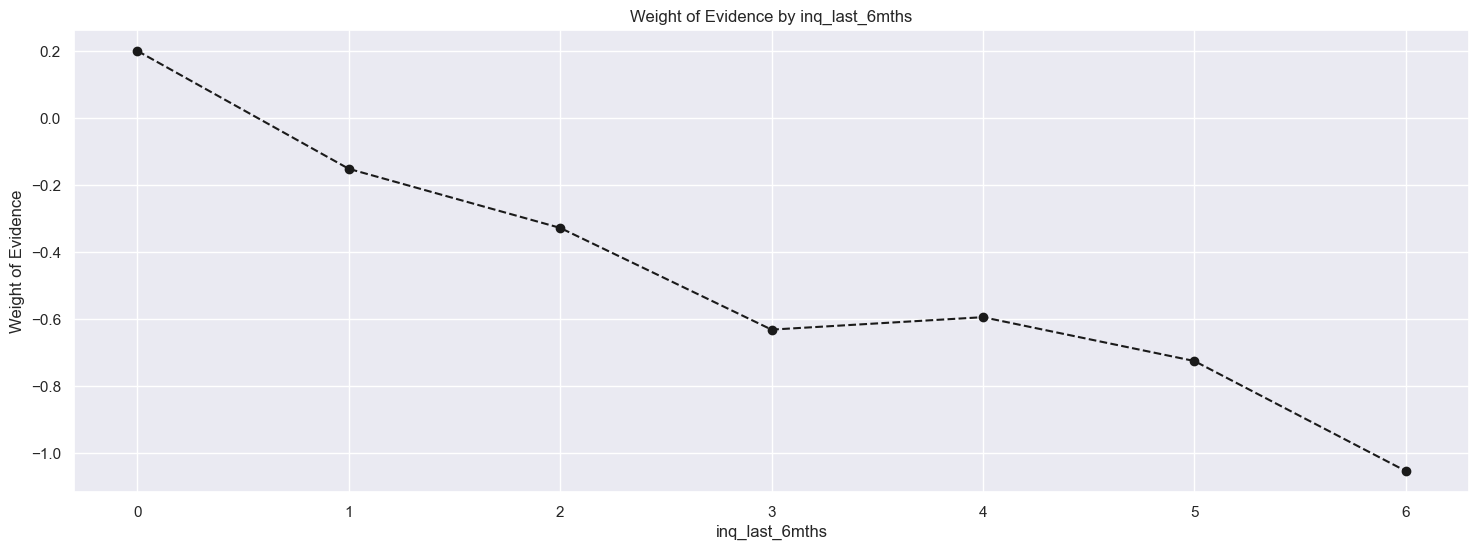

In [80]:
plot_by_woe(df_temp)

#### revol_util

In [81]:
# Initial examination shows that there are some obs with utilization of >1 times which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['revol_util'] <= 1].copy()
# fine-classing
X_train_prepr_temp['revol_util_factor'] = pd.cut(X_train_prepr_temp['revol_util'], 10)
# preprocess 'revol_util'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'revol_util_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 0.1]",1167,0.974293,0.584669,1137.0,30.0,0.585479,0.555556,0.052462,NaN,NaN,0.089857
1,"(0.1, 0.2]",105,0.980952,0.052605,103.0,2.0,0.053038,0.037037,0.359092,0.006659,0.306631,0.089857
2,"(0.2, 0.3]",111,0.963964,0.055611,107.0,4.0,0.055098,0.074074,-0.295955,0.016988,0.655047,0.089857
3,"(0.3, 0.4]",78,0.948718,0.039078,74.0,4.0,0.038105,0.074074,-0.664719,0.015246,0.368764,0.089857
4,"(0.4, 0.5]",110,0.981818,0.055110,108.0,2.0,0.055613,0.037037,0.406494,0.033100,1.071213,0.089857
5,"(0.5, 0.6]",81,0.987654,0.040581,80.0,1.0,0.041195,0.018519,0.799537,0.005836,0.393043,0.089857
6,"(0.6, 0.7]",84,0.964286,0.042084,81.0,3.0,0.041710,0.055556,-0.286653,0.023369,1.086190,0.089857
7,"(0.7, 0.8]",90,0.966667,0.045090,87.0,3.0,0.044799,0.055556,-0.215194,0.002381,0.071459,0.089857
8,"(0.8, 0.9]",70,0.985714,0.035070,69.0,1.0,0.035530,0.018519,0.651617,0.019048,0.866811,0.089857
9,"(0.9, 1.0]",100,0.960000,0.050100,96.0,4.0,0.049434,0.074074,-0.404436,0.025714,1.056053,0.089857


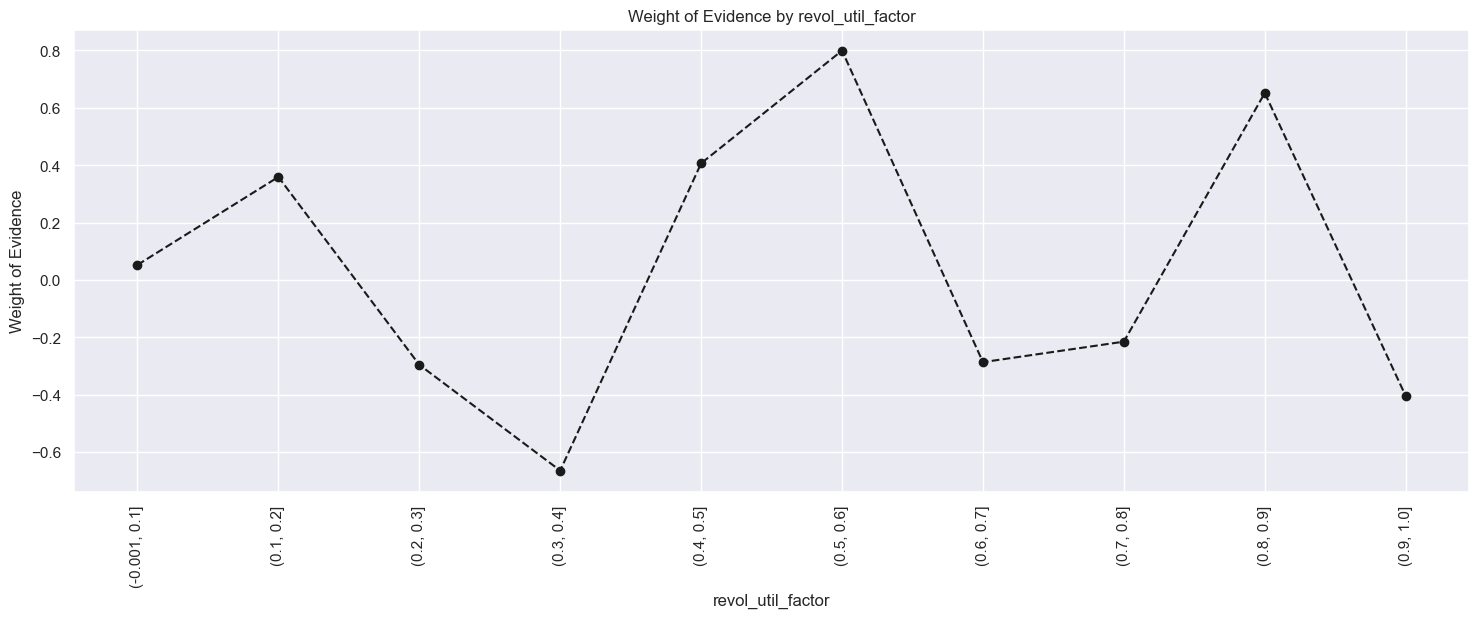

In [82]:
plot_by_woe(df_temp, 90)

#### out_prncp

In [83]:
# Here we do fine-classing: using the 'cut' method, we split the variable into 25 categories by its values.
X_train_prepr['out_prncp_factor'] = pd.cut(X_train_prepr['out_prncp'], 25)
# We calculate weight of evidence.
df_temp = woe_ordered_continuous(X_train_prepr, 'out_prncp_factor', y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-49.373, 1974.914]",26435,0.911821,0.078471,24104.0,2331.0,0.073113,0.324110,-1.489082,NaN,NaN,inf
1,"(1974.914, 3949.829]",17997,0.986887,0.053423,17761.0,236.0,0.053873,0.032814,0.495766,0.075065,1.984848,inf
2,"(3949.829, 5924.743]",32456,0.985088,0.096344,31972.0,484.0,0.096978,0.067297,0.365369,0.001799,0.130398,inf
3,"(5924.743, 7899.658]",30692,0.985566,0.091108,30249.0,443.0,0.091752,0.061596,0.398486,0.000479,0.033118,inf
4,"(7899.658, 9874.572]",35415,0.985543,0.105128,34903.0,512.0,0.105868,0.071190,0.396841,0.000023,0.001645,inf
5,"(9874.572, 11849.486]",32283,0.983149,0.095831,31739.0,544.0,0.096271,0.075640,0.241190,0.002394,0.155651,inf
6,"(11849.486, 13824.401]",25663,0.982270,0.076180,25208.0,455.0,0.076461,0.063265,0.189457,0.000879,0.051733,inf
7,"(13824.401, 15799.315]",27400,0.985584,0.081336,27005.0,395.0,0.081912,0.054922,0.399729,0.003314,0.210272,inf
8,"(15799.315, 17774.23]",19521,0.983505,0.057947,19199.0,322.0,0.058235,0.044772,0.262900,0.002079,0.136830,inf
9,"(17774.23, 19749.144]",20826,0.983962,0.061821,20492.0,334.0,0.062157,0.046440,0.291487,0.000457,0.028587,inf


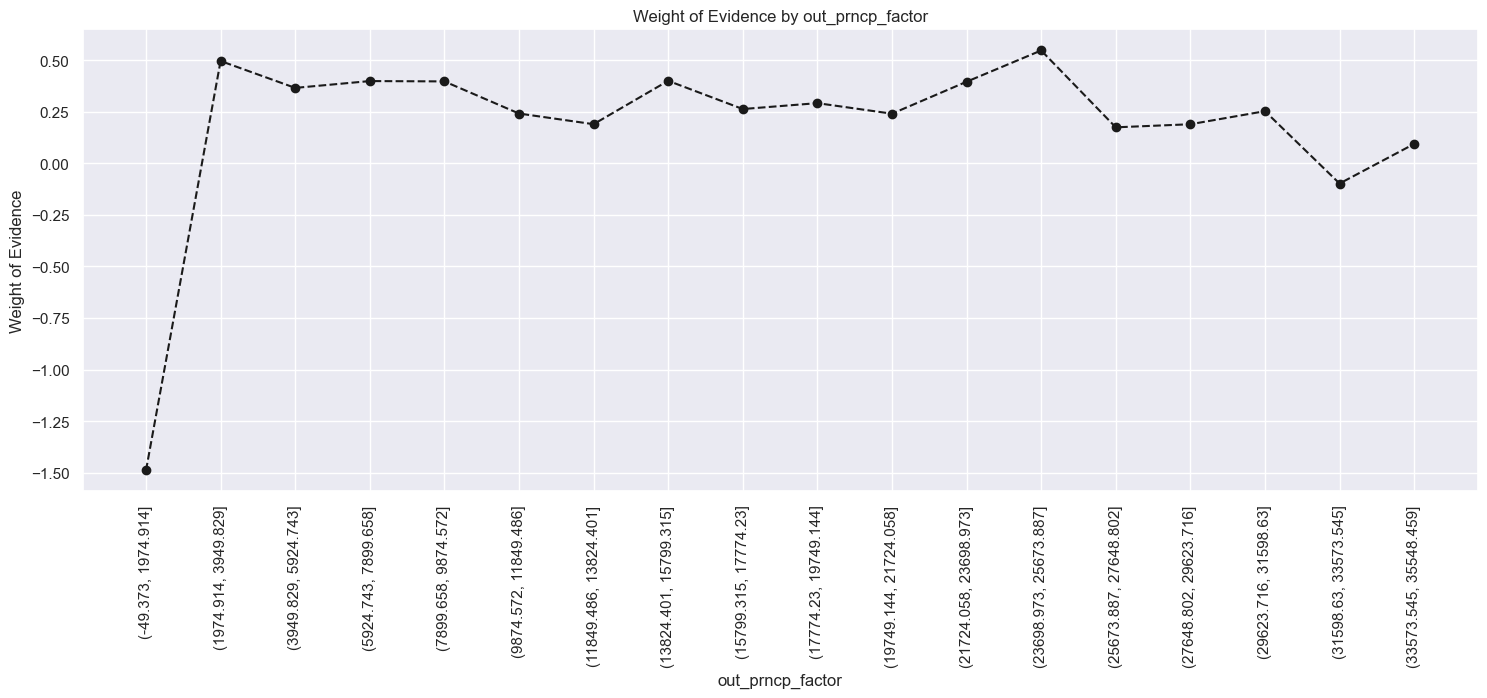

In [84]:
plot_by_woe(df_temp,90)

#### total_pymnt

In [85]:
# Initial examination shows that there are vey few obs with >25,000 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_pymnt'] <= 25000].copy()
# fine-classing
X_train_prepr_temp['total_pymnt_factor'] = pd.cut(X_train_prepr_temp['total_pymnt'], 20)
# preprocess 'total_acc'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_pymnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,total_pymnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-25.0, 1249.98]",117131,0.979886,0.350945,114775.0,2356.0,0.351451,0.327951,0.069205,NaN,NaN,inf
1,"(1249.98, 2499.959]",82098,0.973934,0.245980,79958.0,2140.0,0.244838,0.297884,-0.196108,0.005952,0.265313,inf
2,"(2499.959, 3749.938]",51881,0.975309,0.155444,50600.0,1281.0,0.154941,0.178313,-0.140493,0.001375,0.055615,inf
3,"(3749.938, 4999.918]",30157,0.976888,0.090356,29460.0,697.0,0.090209,0.097021,-0.072800,0.001579,0.067693,inf
4,"(4999.918, 6249.897]",18630,0.982555,0.055819,18305.0,325.0,0.056051,0.045239,0.214301,0.005667,0.287101,inf
5,"(6249.897, 7499.877]",10539,0.982921,0.031577,10359.0,180.0,0.031720,0.025056,0.235851,0.000366,0.021550,inf
6,"(7499.877, 8749.856]",6758,0.985499,0.020248,6660.0,98.0,0.020393,0.013641,0.402104,0.002578,0.166253,inf
7,"(8749.856, 9999.836]",3825,0.986405,0.011460,3773.0,52.0,0.011553,0.007238,0.467579,0.000907,0.065475,inf
8,"(9999.836, 11249.815]",3268,0.991432,0.009791,3240.0,28.0,0.009921,0.003898,0.934321,0.005027,0.466742,inf
9,"(11249.815, 12499.795]",1891,0.994183,0.005666,1880.0,11.0,0.005757,0.001531,1.324328,0.002751,0.390008,inf


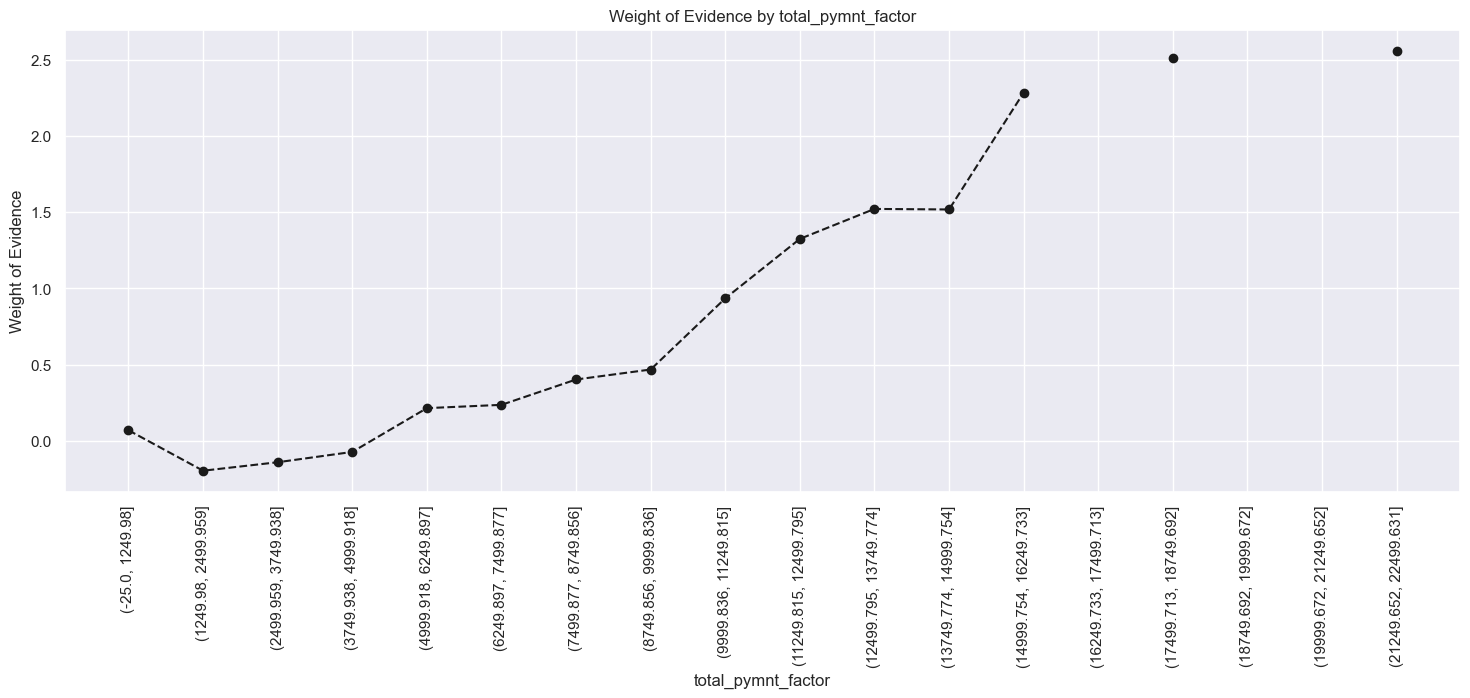

In [86]:
plot_by_woe(df_temp,90)


#### total_rec_int

In [87]:
# Initial examination shows that there are vey few obs with >7,261 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rec_int'] <= 7261].copy()
# fine-classing
X_train_prepr_temp['total_rec_int_factor'] = pd.cut(X_train_prepr_temp['total_rec_int'], 20)
# preprocess 'total_rec_int'
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rec_int_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7.257, 362.854]",126148,0.984320,0.374561,124170.0,1978.0,0.376733,0.275028,0.314664,NaN,NaN,0.062913
1,"(362.854, 725.707]",76931,0.979111,0.228425,75324.0,1607.0,0.228534,0.223443,0.022528,0.005209,0.292136,0.062913
2,"(725.707, 1088.56]",45889,0.975550,0.136254,44767.0,1122.0,0.135823,0.156007,-0.138543,0.003561,0.161071,0.062913
3,"(1088.56, 1451.414]",29088,0.972600,0.086369,28291.0,797.0,0.085835,0.110818,-0.255457,0.002949,0.116914,0.062913
4,"(1451.414, 1814.268]",19311,0.973849,0.057339,18806.0,505.0,0.057058,0.070217,-0.207529,0.001249,0.047928,0.062913
5,"(1814.268, 2177.121]",12703,0.967724,0.037718,12293.0,410.0,0.037297,0.057008,-0.424273,0.006125,0.216745,0.062913
6,"(2177.121, 2539.974]",8343,0.966918,0.024772,8067.0,276.0,0.024475,0.038376,-0.449765,0.000806,0.025492,0.062913
7,"(2539.974, 2902.828]",5614,0.971322,0.016669,5453.0,161.0,0.016544,0.022386,-0.302385,0.004403,0.147381,0.062913
8,"(2902.828, 3265.682]",3883,0.972444,0.011529,3776.0,107.0,0.011456,0.014878,-0.261310,0.001122,0.041075,0.062913
9,"(3265.682, 3628.535]",2763,0.974665,0.008204,2693.0,70.0,0.008171,0.009733,-0.174986,0.002221,0.086324,0.062913


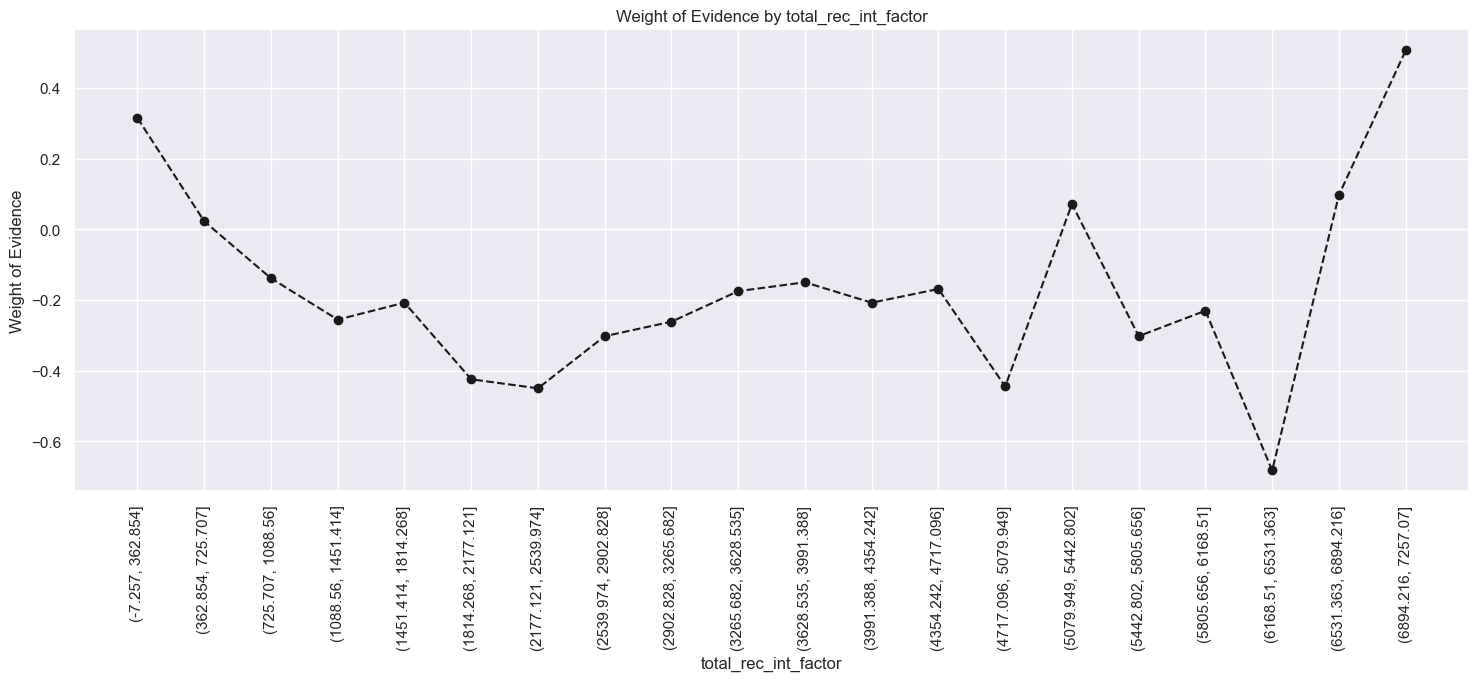

In [88]:
plot_by_woe(df_temp, 90)


#### last_pymnt_amnt

In [89]:
# Initial examination shows that there are vey few obs with 10,000 which should be very rare, so we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['last_pymnt_amnt'] <= 10000].copy()
# fine-classing
X_train_prepr_temp['last_pymnt_amnt_factor'] = pd.cut(X_train_prepr_temp['last_pymnt_amnt'], 15)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'last_pymnt_amnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,last_pymnt_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-10.0, 666.667]",265039,0.978347,0.811075,259300.0,5739.0,0.811334,0.799526,0.014661,NaN,NaN,inf
1,"(666.667, 1333.333]",53790,0.974382,0.164609,52412.0,1378.0,0.163994,0.191975,-0.157538,0.003965,0.172198,inf
2,"(1333.333, 2000.0]",682,0.931085,0.002087,635.0,47.0,0.001987,0.006548,-1.192563,0.043297,1.035025,inf
3,"(2000.0, 2666.667]",500,0.986000,0.001530,493.0,7.0,0.001543,0.000975,0.458559,0.054915,1.651122,inf
4,"(2666.667, 3333.333]",468,0.997863,0.001432,467.0,1.0,0.001461,0.000139,2.350289,0.011863,1.891730,inf
5,"(3333.333, 4000.0]",506,0.998024,0.001548,505.0,1.0,0.001580,0.000139,2.428518,0.000160,0.078229,inf
6,"(4000.0, 4666.667]",584,0.998288,0.001787,583.0,1.0,0.001824,0.000139,2.572147,0.000264,0.143629,inf
7,"(4666.667, 5333.333]",805,0.998758,0.002463,804.0,1.0,0.002516,0.000139,2.893559,0.000470,0.321412,inf
8,"(5333.333, 6000.0]",668,0.997006,0.002044,666.0,2.0,0.002084,0.000279,2.012102,0.001752,0.881457,inf
9,"(6000.0, 6666.667]",654,1.000000,0.002001,654.0,0.0,0.002046,0.000000,inf,0.002994,inf,inf


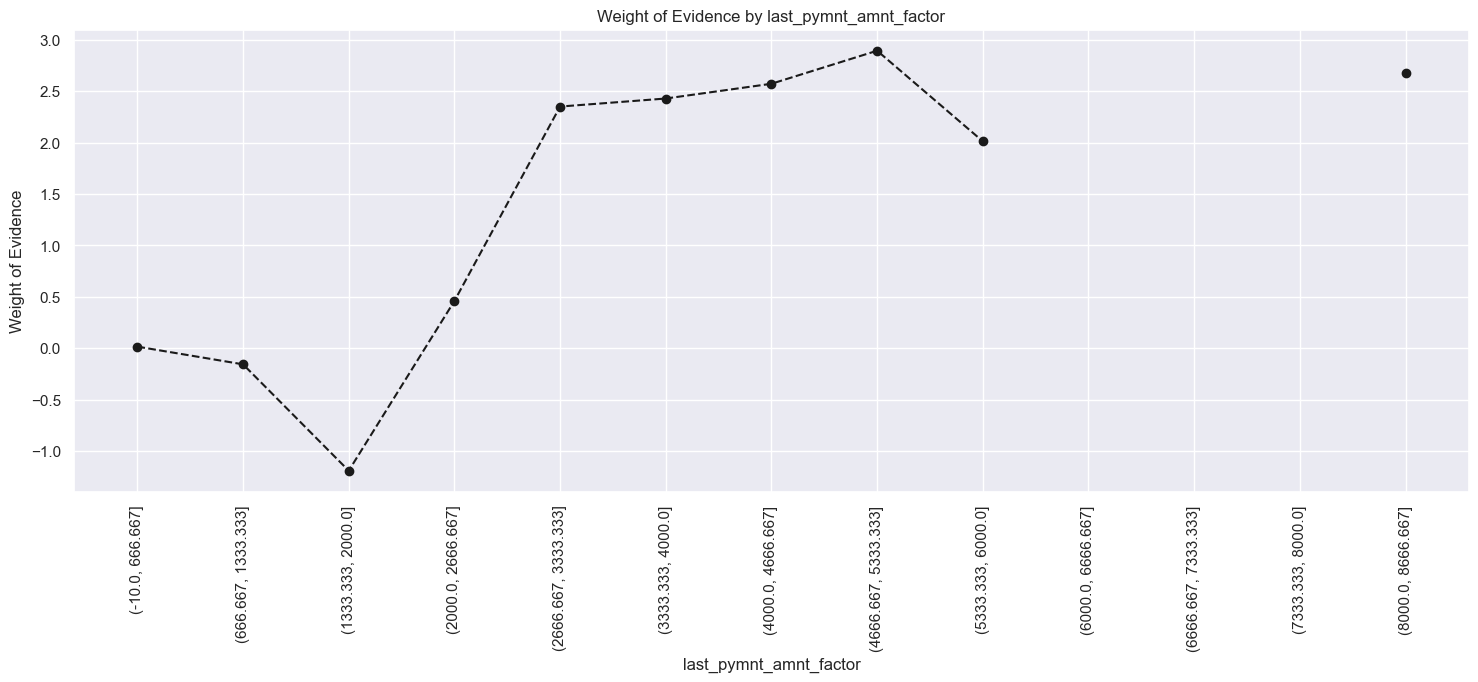

In [90]:
plot_by_woe(df_temp, 90)


#### tot_cur_bal

In [91]:
# Again, because of very few obs > 64,000, we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['tot_cur_bal'] <= 80000].copy()
# fine-classing
X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'tot_cur_bal_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-80.0, 3200.0]",2494,0.974338,0.014774,2430.0,64.0,0.014754,0.015549,-0.052468,NaN,NaN,0.008999
1,"(3200.0, 6400.0]",6259,0.979230,0.037076,6129.0,130.0,0.037214,0.031584,0.164021,0.004891,0.216489,0.008999
2,"(6400.0, 9600.0]",7914,0.980414,0.046880,7759.0,155.0,0.047110,0.037658,0.223952,0.001185,0.059931,0.008999
3,"(9600.0, 12800.0]",9288,0.978144,0.055019,9085.0,203.0,0.055162,0.049320,0.111942,0.002271,0.112010,0.008999
4,"(12800.0, 16000.0]",9715,0.976222,0.057549,9484.0,231.0,0.057584,0.056122,0.025712,0.001922,0.086230,0.008999
5,"(16000.0, 19200.0]",10362,0.975487,0.061381,10108.0,254.0,0.061373,0.061710,-0.005483,0.000735,0.031196,0.008999
6,"(19200.0, 22400.0]",10346,0.975256,0.061286,10090.0,256.0,0.061264,0.062196,-0.015109,0.000231,0.009626,0.008999
7,"(22400.0, 25600.0]",10500,0.975524,0.062199,10243.0,257.0,0.062193,0.062439,-0.003958,0.000268,0.011151,0.008999
8,"(25600.0, 28800.0]",10185,0.974178,0.060333,9922.0,263.0,0.060244,0.063897,-0.058876,0.001346,0.054918,0.008999
9,"(28800.0, 32000.0]",9971,0.976030,0.059065,9732.0,239.0,0.059090,0.058066,0.017479,0.001853,0.076355,0.008999


#### total_rev_hi_lim

In [92]:
# initial examination reveals very few obs > 79,780, we will filter them out first
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rev_hi_lim'] <= 79780].copy()
# fine-classing
X_train_prepr_temp['total_rev_hi_lim_factor'] = pd.cut(X_train_prepr_temp['total_rev_hi_lim'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr_temp, 'total_rev_hi_lim_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-79.755, 3190.2]",3823,0.965211,0.012127,3690.0,133.0,0.011967,0.019228,-0.474188,NaN,NaN,0.040982
1,"(3190.2, 6380.4]",14259,0.969493,0.045230,13824.0,435.0,0.044834,0.062889,-0.338405,0.004282,0.135783,0.040982
2,"(6380.4, 9570.6]",23450,0.971684,0.074384,22786.0,664.0,0.073899,0.095995,-0.261601,0.002191,0.076804,0.040982
3,"(9570.6, 12760.8]",27984,0.973699,0.088766,27248.0,736.0,0.088370,0.106405,-0.185716,0.002015,0.075886,0.040982
4,"(12760.8, 15951.0]",29422,0.976344,0.093327,28726.0,696.0,0.093163,0.100622,-0.077013,0.002645,0.108703,0.040982
5,"(15951.0, 19141.2]",28087,0.975718,0.089092,27405.0,682.0,0.088879,0.098598,-0.103770,0.000626,0.026757,0.040982
6,"(19141.2, 22331.4]",25520,0.978252,0.080950,24965.0,555.0,0.080966,0.080237,0.009041,0.002534,0.112811,0.040982
7,"(22331.4, 25521.6]",22586,0.980342,0.071643,22142.0,444.0,0.071810,0.064190,0.112186,0.002089,0.103145,0.040982
8,"(25521.6, 28711.8]",20013,0.979463,0.063482,19602.0,411.0,0.063573,0.059419,0.067573,0.000878,0.044613,0.040982
9,"(28711.8, 31902.0]",17453,0.978514,0.055361,17078.0,375.0,0.055387,0.054214,0.021399,0.000950,0.046173,0.040982


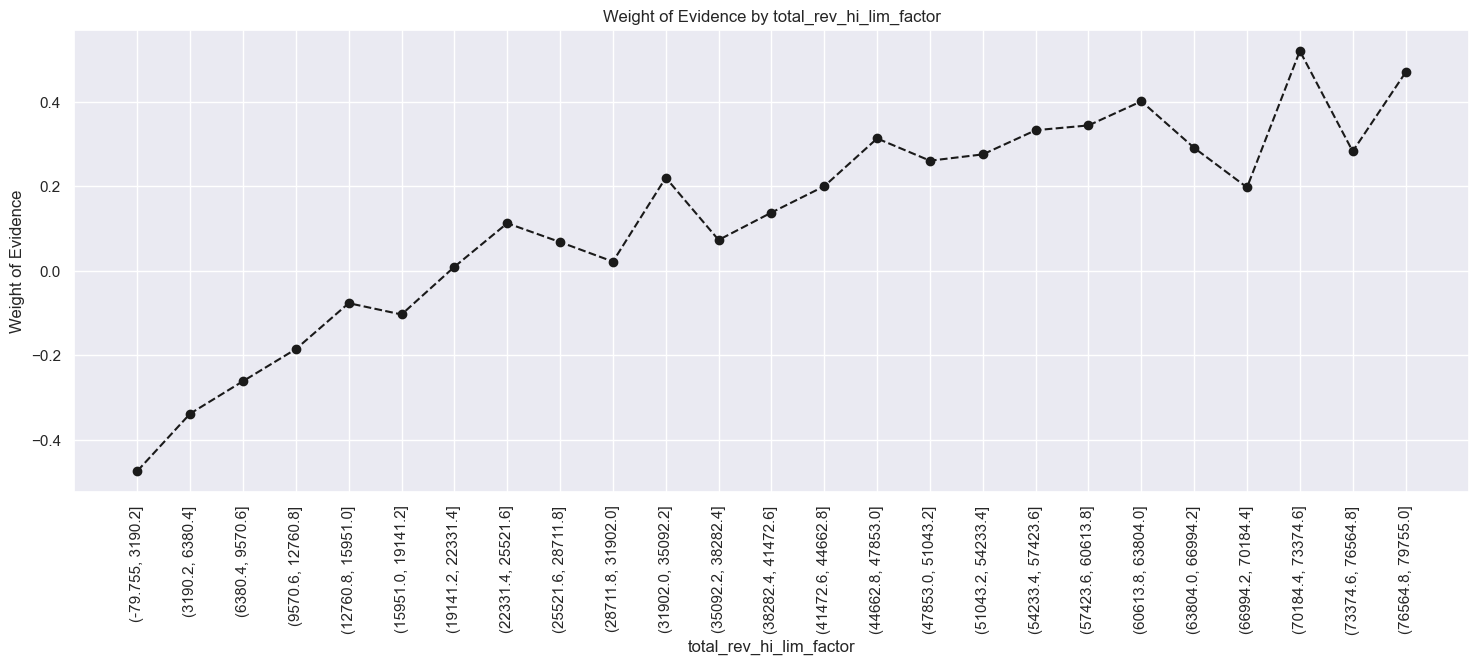

In [93]:
plot_by_woe(df_temp, 90)

#### mths_since_earliest_cr_line_factor

In [94]:
# fine-classing
X_train_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(X_train_prepr['mths_since_earliest_cr_line'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, 'mths_since_earliest_cr_line_factor', y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(92.474, 114.04]",5510,0.975318,0.016356,5374.0,136.0,0.016301,0.018910,-0.148489,NaN,NaN,0.033159
1,"(114.04, 135.08]",8007,0.972274,0.023768,7785.0,222.0,0.023614,0.030868,-0.267886,0.003043,0.119396,0.033159
2,"(135.08, 156.12]",13163,0.969612,0.039074,12763.0,400.0,0.038713,0.055617,-0.362321,0.002662,0.094436,0.033159
3,"(156.12, 177.16]",21386,0.972085,0.063483,20789.0,597.0,0.063058,0.083009,-0.274900,0.002473,0.087421,0.033159
4,"(177.16, 198.2]",34221,0.974665,0.101584,33354.0,867.0,0.101170,0.120551,-0.175268,0.002580,0.099632,0.033159
5,"(198.2, 219.24]",39713,0.977060,0.117886,38802.0,911.0,0.117695,0.126669,-0.073478,0.002396,0.101790,0.033159
6,"(219.24, 240.28]",40279,0.979518,0.119567,39454.0,825.0,0.119673,0.114711,0.042345,0.002457,0.115823,0.033159
7,"(240.28, 261.32]",33590,0.979220,0.099711,32892.0,698.0,0.099769,0.097052,0.027603,0.000298,0.014742,0.033159
8,"(261.32, 282.36]",26672,0.980354,0.079175,26148.0,524.0,0.079313,0.072859,0.084874,0.001134,0.057271,0.033159
9,"(282.36, 303.4]",24335,0.981056,0.072237,23874.0,461.0,0.072415,0.064099,0.121985,0.000702,0.037111,0.033159


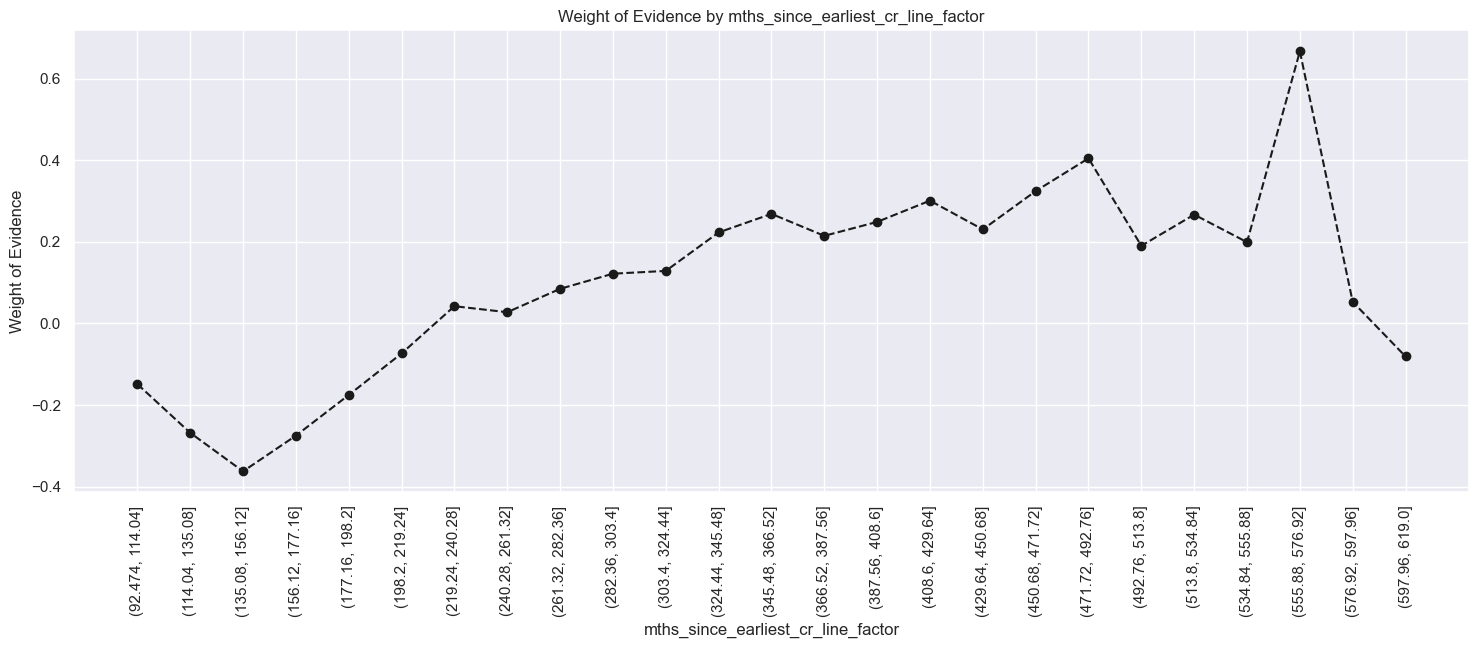

In [95]:
plot_by_woe(df_temp, 90)

#### mths_since_issue_d

In [96]:
# fine-classing
X_train_prepr['mths_since_issue_d_factor'] = pd.cut(X_train_prepr['mths_since_issue_d'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_issue_d_factor", y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(55.989, 56.44]",35445,0.999436,0.105217,35425.0,20.0,0.107452,0.002781,3.654279,NaN,NaN,1.005585
1,"(56.44, 56.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005585
2,"(56.88, 57.32]",29961,0.996295,0.088938,29850.0,111.0,0.090542,0.015434,1.769248,NaN,NaN,1.005585
3,"(57.32, 57.76]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005585
4,"(57.76, 58.2]",38947,0.995532,0.115613,38773.0,174.0,0.117607,0.024194,1.581262,NaN,NaN,1.005585
5,"(58.2, 58.64]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005585
6,"(58.64, 59.08]",22858,0.991250,0.067853,22658.0,200.0,0.068727,0.027809,0.904789,NaN,NaN,1.005585
7,"(59.08, 59.52]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005585
8,"(59.52, 59.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005585
9,"(59.96, 60.4]",28817,0.988722,0.085542,28492.0,325.0,0.086422,0.045189,0.648391,NaN,NaN,1.005585


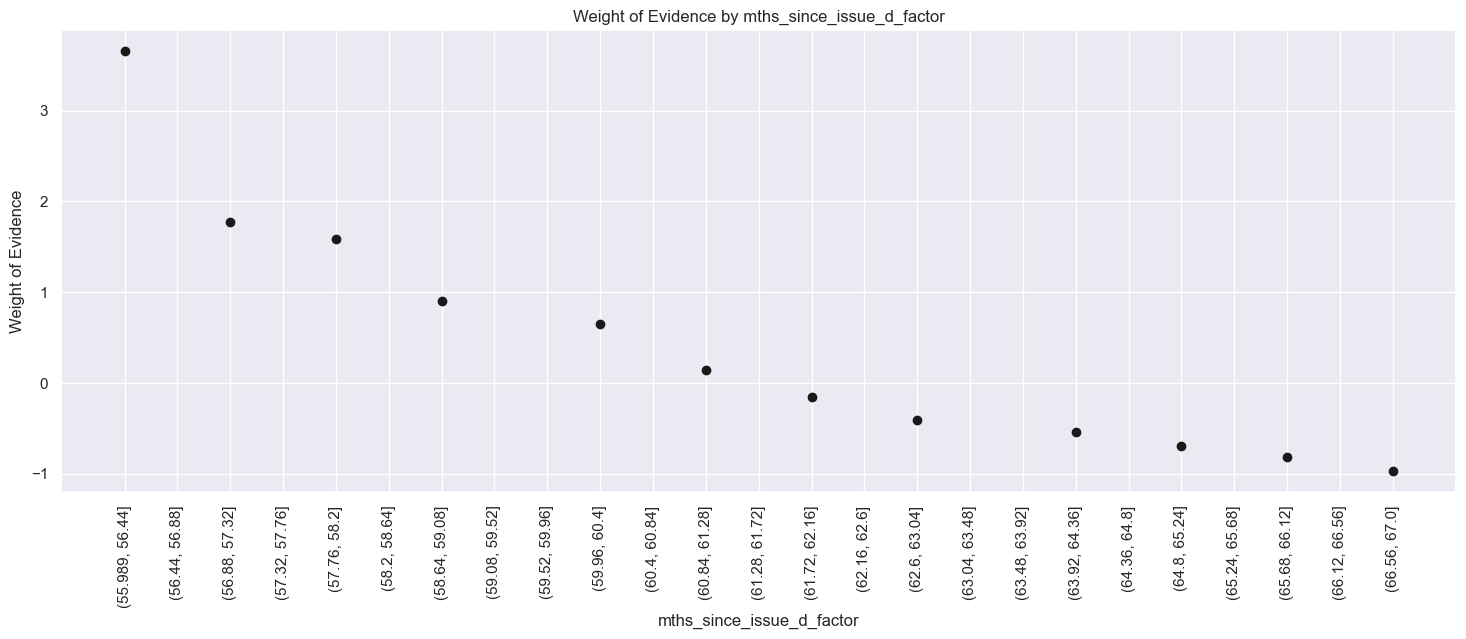

In [97]:
plot_by_woe(df_temp, 90)

#### mths_since_last_pymnt_d

In [98]:
# fine-classing
X_train_prepr['mths_since_last_pymnt_d_factor'] = pd.cut(X_train_prepr['mths_since_last_pymnt_d'], 25)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_last_pymnt_d_factor", y_train_prepr)
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,mths_since_last_pymnt_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(54.988, 55.48]",232434,0.998460,0.719692,232076.0,358.0,0.734320,0.051727,2.652972,NaN,NaN,inf
1,"(55.48, 55.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(55.96, 56.44]",70908,0.983331,0.219555,69726.0,1182.0,0.220623,0.170785,0.256051,NaN,NaN,inf
3,"(56.44, 56.92]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(56.92, 57.4]",3708,0.692287,0.011481,2567.0,1141.0,0.008122,0.164861,-3.010482,NaN,NaN,inf
5,"(57.4, 57.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(57.88, 58.36]",3841,0.671960,0.011893,2581.0,1260.0,0.008167,0.182055,-3.104250,NaN,NaN,inf
7,"(58.36, 58.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(58.84, 59.32]",2908,0.699450,0.009004,2034.0,874.0,0.006436,0.126282,-2.976636,NaN,NaN,inf
9,"(59.32, 59.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


#### mths_since_last_credit_pull_d

In [99]:
# filter out all values > 75 given the low obs
X_train_prepr_temp = X_train_prepr[X_train_prepr['mths_since_last_credit_pull_d'] <= 75].copy()
# Here we do fine-classing: using the 'cut' method, we split the variable into 25 categories
X_train_prepr_temp['mths_since_last_credit_pull_d_factor'] = pd.cut(X_train_prepr_temp['mths_since_last_credit_pull_d'], 25)
# Calculate WoE
df_temp = woe_ordered_continuous(X_train_prepr_temp, "mths_since_last_credit_pull_d_factor", y_train_prepr[X_train_prepr_temp.index])
df_temp

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\2975529868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,mths_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(54.987, 55.52]",322204,0.980494,0.956478,315919.0,6285.0,0.958277,0.874009,0.092046,NaN,NaN,inf
1,"(55.52, 56.04]",4283,0.882792,0.012714,3781.0,502.0,0.011469,0.069809,-1.806130,0.097701,1.898176,inf
2,"(56.04, 56.56]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(56.56, 57.08]",2526,0.987332,0.007499,2494.0,32.0,0.007565,0.004450,0.530633,NaN,NaN,inf
4,"(57.08, 57.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(57.6, 58.12]",1956,0.982618,0.005806,1922.0,34.0,0.005830,0.004728,0.209487,NaN,NaN,inf
6,"(58.12, 58.64]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(58.64, 59.16]",1614,0.916976,0.004791,1480.0,134.0,0.004489,0.018634,-1.423316,NaN,NaN,inf
8,"(59.16, 59.68]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(59.68, 60.2]",1150,0.923478,0.003414,1062.0,88.0,0.003221,0.012238,-1.334702,NaN,NaN,inf


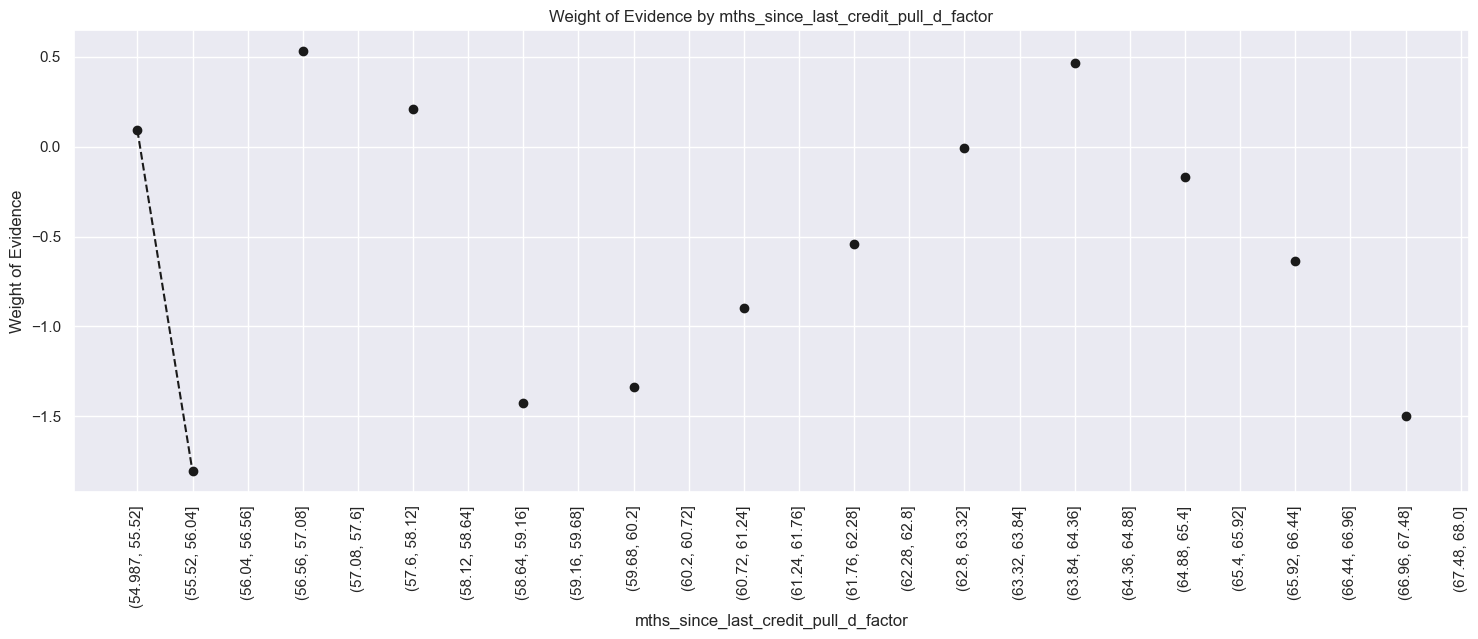

In [100]:
plot_by_woe(df_temp, 90)

### WOE

In [101]:
from woe import WoE_Binning

In [102]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(336875, 49)
(336875,)
(84219, 49)
(84219,)


# Model

In [103]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')

woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7990
Gini: 0.5980


In [104]:
import pickle

# training model
pipeline.fit(X_train, y_train)

# save model
with open('pipeline_model', 'wb') as file:
    pickle.dump(pipeline, file)

In [105]:
# first create a transformed training set through our WoE_Binning custom class
woe_transform_instance = pipeline.named_steps['woe']

X_train_woe_transformed = woe_transform_instance .fit_transform(X_train)

# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values

# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)

# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1

# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]

# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,1.326834
1,grade:A,1.870219
2,grade:B,1.438423
3,grade:C,1.143880
4,grade:D,1.026466
...,...,...
80,mths_since_issue_d:100-122,0.000000
81,mths_since_last_credit_pull_d:missing,-0.349670
82,mths_since_last_credit_pull_d:<56,0.445337
83,mths_since_last_credit_pull_d:56-61,0.312285


In [106]:
summary_table.to_csv('feature_score.csv', index=True)

In [107]:
# predict on test set
y_hat_train = pipeline.predict(X_train)

# predicted probabilities of 1-class (good)
y_hat_train_proba = pipeline.predict_proba(X_train)[: ,1]

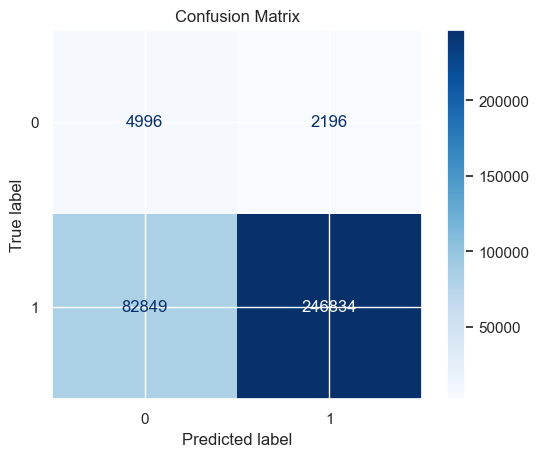

In [108]:
cm = confusion_matrix(y_train, y_hat_train)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [109]:
accuracy = accuracy_score(y_train, y_hat_train)
precision = precision_score(y_train, y_hat_train)
recall = recall_score(y_train, y_hat_train)
f1 = f1_score(y_train, y_hat_train)
auc = roc_auc_score(y_train, y_hat_train)

# calculate Gini from AUROC
Gini = auc * 2 - 1
Gini

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {Gini:.2f}')

Accuracy: 0.75
Precision: 0.99
Recall: 0.75
F1-Score: 0.85
AUC: 0.72
Gini: 0.44


# Prediction

In [110]:
# predict on test set
y_hat_test = pipeline.predict(X_test)

# predicted probabilities of 1-class (good)
y_hat_test_proba = pipeline.predict_proba(X_test)[: ,1]

In [111]:
pipeline.predict_proba(X_test)

array([[0.70347322, 0.29652678],
       [0.37685209, 0.62314791],
       [0.30110192, 0.69889808],
       ...,
       [0.23849854, 0.76150146],
       [0.09790767, 0.90209233],
       [0.50491009, 0.49508991]])

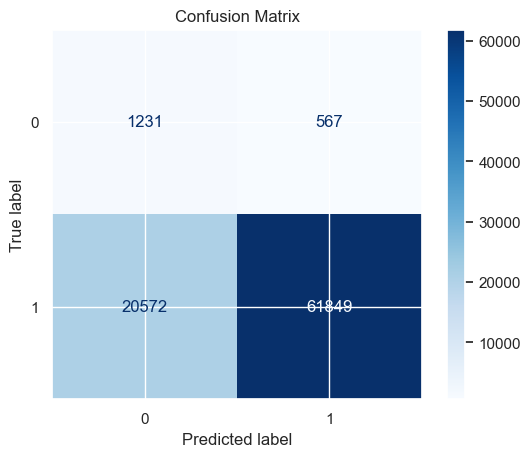

In [112]:
cm = confusion_matrix(y_test, y_hat_test)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [113]:
accuracy = accuracy_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)
auc = roc_auc_score(y_test, y_hat_test)

# calculate Gini from AUROC
Gini = auc * 2 - 1
Gini

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {Gini:.2f}')

Accuracy: 0.75
Precision: 0.99
Recall: 0.75
F1-Score: 0.85
AUC: 0.72
Gini: 0.44


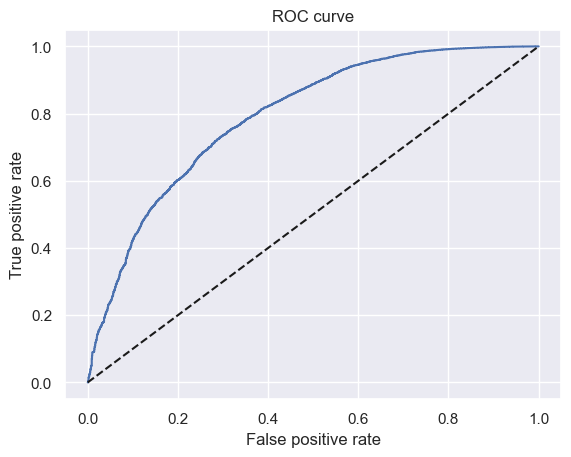

In [114]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba)

# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

## Applying the Model - Scorecard Creation

In [115]:
summary_table

,Feature name,Coefficients
0,Intercept,1.326834
1,grade:A,1.870219
2,grade:B,1.438423
3,grade:C,1.143880
4,grade:D,1.026466
...,...,...
80,mths_since_issue_d:100-122,0.000000
81,mths_since_last_credit_pull_d:missing,-0.349670
82,mths_since_last_credit_pull_d:<56,0.445337
83,mths_since_last_credit_pull_d:56-61,0.312285


In [116]:
# create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])

# create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,grade:G,0
1,home_ownership:MORTGAGE,0
2,verification_status:Not Verified,0
3,purpose:major_purch__car__home_impr,0
4,term:60,0
5,int_rate:>20.281,0
6,annual_inc:>150K,0
7,dti:>35.191,0
8,inq_last_6mths:>4,0
9,revol_util:>1.0,0


In [117]:
# concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])

# reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,1.326834
1,1,grade:A,1.870219
2,2,grade:B,1.438423
3,3,grade:C,1.143880
4,4,grade:D,1.026466
...,...,...,...
97,12,"total_rec_int:>7,260",0.000000
98,13,"total_rev_hi_lim:>79,780",0.000000
99,14,mths_since_earliest_cr_line:>434,0.000000
100,15,mths_since_issue_d:>122,0.000000


In [118]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,1.326834,Intercept
1,1,grade:A,1.870219,grade
2,2,grade:B,1.438423,grade
3,3,grade:C,1.143880,grade
4,4,grade:D,1.026466,grade
...,...,...,...,...
97,12,"total_rec_int:>7,260",0.000000,total_rec_int
98,13,"total_rev_hi_lim:>79,780",0.000000,total_rev_hi_lim
99,14,mths_since_earliest_cr_line:>434,0.000000,mths_since_earliest_cr_line
100,15,mths_since_issue_d:>122,0.000000,mths_since_issue_d


In [119]:
# Define the min and max threshholds for scorecard
min_score = 300
max_score = 850

In [120]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()

# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()

# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,1.326834,Intercept,578.734760,579.0
1,1,grade:A,1.870219,grade,52.222345,52.0
2,2,grade:B,1.438423,grade,40.165243,40.0
3,3,grade:C,1.143880,grade,31.940700,32.0
4,4,grade:D,1.026466,grade,28.662128,29.0
...,...,...,...,...,...,...
97,12,"total_rec_int:>7,260",0.000000,total_rec_int,0.000000,0.0
98,13,"total_rev_hi_lim:>79,780",0.000000,total_rev_hi_lim,0.000000,0.0
99,14,mths_since_earliest_cr_line:>434,0.000000,mths_since_earliest_cr_line,0.000000,0.0
100,15,mths_since_issue_d:>122,0.000000,mths_since_issue_d,0.000000,0.0


In [121]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
849.0


## Calculating credit scores in the test set

In [122]:
# create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)

# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:ANY_RENT,verification_status:Source Verified,verification_status:Verified,purpose:debt_consolidation,purpose:credit_card,purpose:educ__ren_en__sm_b__mov,purpose:vacation__house__wedding__med__oth,term:36,int_rate:<7.071,int_rate:7.071-10.374,int_rate:10.374-13.676,int_rate:13.676-15.74,int_rate:15.74-20.281,annual_inc:missing,"annual_inc:<28,555","annual_inc:28,555-37,440","annual_inc:37,440-61,137","annual_inc:61,137-81,872","annual_inc:81,872-102,606","annual_inc:102,606-120,379","annual_inc:120,379-150,000",dti:<=1.6,dti:1.6-5.599,dti:5.599-10.397,dti:10.397-15.196,dti:15.196-19.195,dti:19.195-24.794,dti:24.794-35.191,inq_last_6mths:missing,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-4,revol_util:missing,revol_util:<0.1,revol_util:0.1-0.2,revol_util:0.2-0.3,revol_util:0.3-0.4,revol_util:0.4-0.5,revol_util:0.5-0.6,revol_util:0.6-0.7,revol_util:0.7-0.8,revol_util:0.8-0.9,revol_util:0.9-1.0,"out_prncp:<1,286","out_prncp:1,286-6,432","out_prncp:6,432-9,005","out_prncp:9,005-10,291","out_prncp:10,291-15,437","total_pymnt:<10,000","total_pymnt:10,000-15,000","total_pymnt:15,000-20,000","total_pymnt:20,000-25,000","total_rec_int:<1,089","total_rec_int:1,089-2,541","total_rec_int:2,541-4,719","total_rec_int:4,719-7,260",total_rev_hi_lim:missing,"total_rev_hi_lim:<6,381","total_rev_hi_lim:6,381-19,144","total_rev_hi_lim:19,144-25,525","total_rev_hi_lim:25,525-35,097","total_rev_hi_lim:35,097-54,241","total_rev_hi_lim:54,241-79,780",mths_since_earliest_cr_line:missing,mths_since_earliest_cr_line:<125,mths_since_earliest_cr_line:125-167,mths_since_earliest_cr_line:167-249,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61,mths_since_last_credit_pull_d:61-75
256888,1,False,False,False,False,True,False,False,1,False,True,True,False,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
64807,1,False,True,False,False,False,False,False,1,False,True,True,False,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
38259,1,False,True,False,False,False,False,False,1,False,True,False,False,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
84320,1,False,True,False,False,False,False,False,0,False,True,False,False,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
86544,1,False,True,False,False,False,False,False,0,False,True,False,True,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [123]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Preliminary']

# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(84219, 85)
(102,)


In [124]:
scorecard_scores_series = pd.Series(scorecard_scores, name='Score - Preliminary')
scorecard_scores_series.to_csv('scorecard_scores.csv', index=False)


In [125]:
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                 index = X_test_woe_transformed.index)], axis = 1)
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(84219, 102)
(102, 1)


In [126]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
256888,515.0
64807,554.0
38259,563.0
84320,573.0
86544,591.0


# Setting loan approval cut-offs

In [127]:
fpr, tpr, thresholds = roc_curve(y_train, pipeline.predict_proba(X_train)[:,1],drop_intermediate=False)

# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr

max_index = np.argmax(J)

best_thresh = thresholds[max_index]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.500479


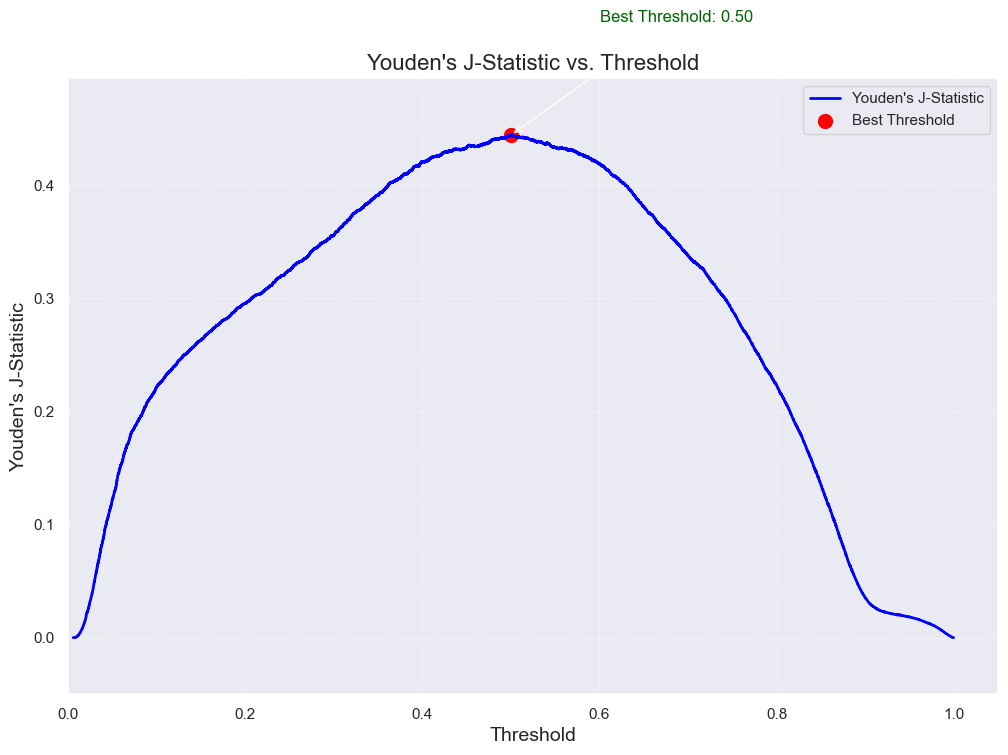

In [128]:
plt.figure(figsize=(12, 8))
plt.plot(thresholds, J, color='blue', linestyle='-', linewidth=2, label='Youden\'s J-Statistic')
plt.scatter(best_thresh, J[max_index], color='red', s=100, label='Best Threshold')  # Đánh dấu ngưỡng tốt nhất
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Youden's J-Statistic", fontsize=14)
plt.title("Youden's J-Statistic vs. Threshold", fontsize=16)
plt.legend(loc='best')

# Thêm chú thích cho ngưỡng tốt nhất
plt.annotate(f'Best Threshold: {best_thresh:.2f}', 
             xy=(best_thresh, J[max_index]), 
             xytext=(best_thresh + 0.1, J[max_index] + 0.1),
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             fontsize=12,
             color='darkgreen')

# Thêm lưới cho biểu đồ
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Điều chỉnh giới hạn trục
plt.xlim([0.0, 1.05])
plt.ylim([J.min() - 0.05, J.max() + 0.05])

# Hiển thị biểu đồ
plt.show()



In [129]:
y_pred = np.where(y_hat_test_proba > best_thresh, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {Gini:.2f}')

Accuracy: 0.75
Precision: 0.99
Recall: 0.75
F1-Score: 0.85
AUC: 0.72
Gini: 0.60


In [130]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])

# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs

,thresholds,Score
0,inf,NaN
1,0.999877,793.0
2,0.999856,789.0
3,0.999831,784.0
4,0.999823,783.0
...,...,...
277787,0.009276,411.0
277788,0.008850,410.0
277789,0.008791,410.0
277790,0.008121,408.0


In [131]:

def n_approved(p):
    return np.where(y_hat_test_proba >= p, 1, 0).sum()

df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)

df_cutoffs['N Rejected'] = y_hat_test_proba.shape[0] - df_cutoffs['N Approved']

df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_hat_test_proba.shape[0]

df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs


,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,inf,NaN,0,84219,0.000000,1.000000
1,0.999877,793.0,0,84219,0.000000,1.000000
2,0.999856,789.0,0,84219,0.000000,1.000000
3,0.999831,784.0,0,84219,0.000000,1.000000
4,0.999823,783.0,0,84219,0.000000,1.000000
...,...,...,...,...,...,...
277787,0.009276,411.0,84218,1,0.999988,0.000012
277788,0.008850,410.0,84218,1,0.999988,0.000012
277789,0.008791,410.0,84218,1,0.999988,0.000012
277790,0.008121,408.0,84218,1,0.999988,0.000012


In [132]:
filtered_cutoffs = df_cutoffs[(df_cutoffs['thresholds'] == best_thresh)]
filtered_cutoffs

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
200139,0.500479,542.0,62370,21849,0.740569,0.259431


# Monitoring

In [133]:
monitor_data = pd.read_csv('data/lc_2016_2017.csv')
monitor_data.shape

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\390578206.py:1: DtypeWarning: Columns (18,54) have mixed types. Specify dtype option on import or set low_memory=False.
  monitor_data = pd.read_csv('data/lc_2016_2017.csv')


(759338, 72)

In [134]:
monitor_data['loan_status'].value_counts(normalize=True)

loan_status
Current               0.744758
Fully Paid            0.172147
Charged Off           0.048986
Late (31-120 days)    0.020220
In Grace Period       0.008737
Late (16-30 days)     0.005104
Default               0.000047
Name: proportion, dtype: float64

In [135]:
monitor_data_loan = monitor_data.copy()
# xóa những bản ghi có trạng thái là issued (vừa mới được cấp phát)
# loan_data = loan_data[~data['loan_status'].isin(['Issued'])]
monitor_data_loan['target'] = np.where(monitor_data_loan['loan_status'].isin(['Charged Off', 'Default',
                                                             'Late (31-120 days)',  'Late (16-30 days)']), 0, 1)
monitor_data_loan['target'].value_counts(normalize=True)
monitor_data_loan.drop(columns = ['loan_status'], inplace = True)

In [136]:
features_to_keep = ['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'inq_last_6mths',
       'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'earliest_cr_line', 'issue_d',
       'last_pymnt_d', 'last_credit_pull_d']

In [137]:
y_monitor = monitor_data_loan['target']
X_monitor = monitor_data_loan.drop(columns = ['target'])

In [138]:
X_monitor = monitor_data_loan[features_to_keep]
X_monitor.shape

(759338, 21)

In [139]:
def calculate_month_difference(date_series, reference_date):
    # Calculate the difference in years and months
    year_diff = reference_date.year - date_series.dt.year
    month_diff = reference_date.month - date_series.dt.month
    
    # Total month difference
    total_month_diff = year_diff * 12 + month_diff
    
    return total_month_diff


def date_columns(df, column):
    today_date = pd.to_datetime('2020-08-01')
    
    df[column] = pd.to_datetime(df[column], format = "%b-%Y")
    
    df['mths_since_' + column] = calculate_month_difference(df[column], today_date)

    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    
    df.drop(columns = [column], inplace = True)

In [140]:
date_columns(X_monitor, 'earliest_cr_line')
date_columns(X_monitor, 'issue_d')
date_columns(X_monitor, 'last_pymnt_d')
date_columns(X_monitor, 'last_credit_pull_d')

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\3746004257.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format = "%b-%Y")
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\3746004257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mths_since_' + column] = calculate_month_difference(df[column], today_date)
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\3746004257.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [141]:
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
loan_term_converter(X_monitor, 'term')

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\605597488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column].str.replace(' months', ''))


In [142]:
# convert column emp_length values to numeric.
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', '0')
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = df[column].str.replace('\+', '', regex=True)  
    df[column] = pd.to_numeric(df[column])
    
emp_length_converter(X_monitor, 'emp_length')
X_monitor['emp_length']

C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\598068875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace('\+ years', '')
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\598068875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace('< 1 year', '0')
C:\Users\uyenn\AppData\Local\Temp\ipykernel_1620\598068875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

0          NaN
1         10.0
2          7.0
3         10.0
4         10.0
          ... 
759333     0.0
759334     NaN
759335    10.0
759336    10.0
759337     7.0
Name: emp_length, Length: 759338, dtype: float64

In [143]:
X_monitor.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
0,36,12.62,C,NaN,OWN,10000.0,Not Verified,credit_card,21.61,1.0,55.1,2029.91,382.99,112.90,77.08,3911.0,7100.0,419,38,32.0,32.0
1,60,12.62,C,10.0,MORTGAGE,94000.0,Not Verified,debt_consolidation,25.61,0.0,105.8,14813.07,2060.09,873.16,360.95,234457.0,31900.0,338,38,32.0,32.0
2,36,15.05,C,7.0,MORTGAGE,46350.0,Not Verified,home_improvement,8.88,0.0,44.9,5340.82,1032.46,348.28,209.01,121311.0,27700.0,218,38,32.0,32.0
3,36,9.44,B,10.0,RENT,44000.0,Source Verified,car,27.06,1.0,18.7,17898.81,3237.80,736.61,652.91,62335.0,46900.0,163,38,32.0,32.0
4,36,11.99,B,10.0,MORTGAGE,85000.0,Source Verified,debt_consolidation,6.79,0.0,88.0,11460.66,2137.00,597.66,431.73,15332.0,7800.0,222,38,32.0,32.0


In [144]:
X_monitor = dummy_creation(X_monitor, ['grade', 'home_ownership', 'verification_status', 'purpose'])

# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_monitor = X_monitor.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [145]:
y_train = y_train.to_frame(name='y')

data_org = pd.concat([X_train, y_train], axis=1)


In [146]:
y_monitor = y_monitor.to_frame(name='y')
data_mo = pd.concat([X_monitor, y_monitor], axis=1)
data_mo.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,y
0,36,12.62,C,NaN,OWN,10000.0,Not Verified,credit_card,21.61,1.0,55.1,2029.91,382.99,112.90,77.08,3911.0,7100.0,419,38,32.0,32.0,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,0,False,False,False,False,False,False,False,False,False,False,1
1,60,12.62,C,10.0,MORTGAGE,94000.0,Not Verified,debt_consolidation,25.61,0.0,105.8,14813.07,2060.09,873.16,360.95,234457.0,31900.0,338,38,32.0,32.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,0,False,False,False,False,False,False,False,False,False,False,1
2,36,15.05,C,7.0,MORTGAGE,46350.0,Not Verified,home_improvement,8.88,0.0,44.9,5340.82,1032.46,348.28,209.01,121311.0,27700.0,218,38,32.0,32.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,0,True,False,False,False,False,False,False,False,False,False,1
3,36,9.44,B,10.0,RENT,44000.0,Source Verified,car,27.06,1.0,18.7,17898.81,3237.80,736.61,652.91,62335.0,46900.0,163,38,32.0,32.0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,0,False,False,False,False,False,False,False,False,False,False,1
4,36,11.99,B,10.0,MORTGAGE,85000.0,Source Verified,debt_consolidation,6.79,0.0,88.0,11460.66,2137.00,597.66,431.73,15332.0,7800.0,222,38,32.0,32.0,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,0,False,False,False,False,False,False,False,False,False,False,1


In [147]:
data_org.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,y
112270,60,7.89,A,0.0,RENT,135000.0,Verified,credit_card,24.75,1,85.0,26845.94,1668.13,514.07,566.27,238610,45300,350,58,55.0,55.0,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1
74514,36,11.53,B,2.0,RENT,145000.0,Source Verified,other,10.16,1,14.5,5718.05,388.21,106.26,197.95,44216,20500,111,58,55.0,55.0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1
33120,36,9.17,B,6.0,RENT,52000.0,Verified,debt_consolidation,20.02,1,53.6,9367.33,328.04,95.37,337.82,24566,11500,313,56,55.0,55.0,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1
142484,36,6.24,A,5.0,MORTGAGE,56000.0,Not Verified,car,5.25,0,2.8,3264.67,1009.28,73.95,128.23,152110,17900,216,59,55.0,55.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
65418,36,8.18,B,10.0,OWN,120000.0,Source Verified,debt_consolidation,14.44,0,83.4,19986.91,1302.09,264.00,660.60,242624,58300,400,57,55.0,55.0,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1


In [158]:
import scorecardpy as sc

drop_f = ['grade', 'home_ownership', 'verification_status', 'purpose', 'grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E',
          'grade:F', 'grade:G', 'home_ownership:ANY', 'home_ownership:MORTGAGE', 'home_ownership:OWN', 'home_ownership:RENT', "verification_status:Not Verified",
            "verification_status:Source Verified",
            "verification_status:Verified",
            "purpose:car",
            "purpose:credit_card",
            "purpose:debt_consolidation",
            "purpose:educational",
            "purpose:home_improvement",
            "purpose:house",
            "purpose:major_purchase",
            "purpose:medical",
            "purpose:moving",
            "purpose:other",
            "purpose:renewable_energy",
            "purpose:small_business",
            "purpose:vacation",
            "purpose:wedding" ]

data_mo_cleaned = data_mo.drop(columns=drop_f, errors='ignore')  
data_org_cleaned = data_org.drop(columns=drop_f, errors='ignore') 

data_mo_cleaned = data_mo_cleaned.astype(float)
data_org_cleaned = data_org_cleaned.astype(float)


In [159]:
print(data_mo_cleaned.dtypes)
print(data_org_cleaned.dtypes)


term                             float64
int_rate                         float64
emp_length                       float64
annual_inc                       float64
dti                              float64
inq_last_6mths                   float64
revol_util                       float64
out_prncp                        float64
total_pymnt                      float64
total_rec_int                    float64
last_pymnt_amnt                  float64
tot_cur_bal                      float64
total_rev_hi_lim                 float64
mths_since_earliest_cr_line      float64
mths_since_issue_d               float64
mths_since_last_pymnt_d          float64
mths_since_last_credit_pull_d    float64
y                                float64
dtype: object
term                             float64
int_rate                         float64
emp_length                       float64
annual_inc                       float64
dti                              float64
inq_last_6mths                   float64
re

In [160]:
rows_with_nan_mo = data_mo_cleaned[data_mo_cleaned.isnull().any(axis=1)]
rows_with_nan_org = data_org_cleaned[data_org_cleaned.isnull().any(axis=1)]
rows_with_nan_mo, rows_with_nan_org

(        term  int_rate  emp_length  annual_inc    dti  inq_last_6mths  \
 0       36.0     12.62         NaN     10000.0  21.61             1.0   
 14      36.0     10.91         NaN     85000.0  20.82             0.0   
 43      36.0     10.91         NaN     24000.0  24.85             0.0   
 46      60.0     12.62         NaN    140000.0  21.70             0.0   
 51      36.0     12.62         NaN     67000.0  14.87             0.0   
 ...      ...       ...         ...         ...    ...             ...   
 759308  36.0      7.89         NaN     36000.0  14.20             0.0   
 759320  60.0     18.99         NaN     90000.0  18.23             1.0   
 759325  36.0     15.41         NaN     36000.0  38.57             1.0   
 759328  36.0     26.77         NaN     20000.0  29.11             2.0   
 759334  36.0      9.17         NaN     32640.0  22.76             1.0   
 
         revol_util  out_prncp   total_pymnt  total_rec_int  last_pymnt_amnt  \
 0             55.1    2029.91

In [161]:
data_mo_cleaned = data_mo_cleaned.fillna(0)
data_org_cleaned = data_org_cleaned.fillna(0)

d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:462: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  score[i].copy(deep=True).loc[:,'y'] = np.nan
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:504: SettingWit

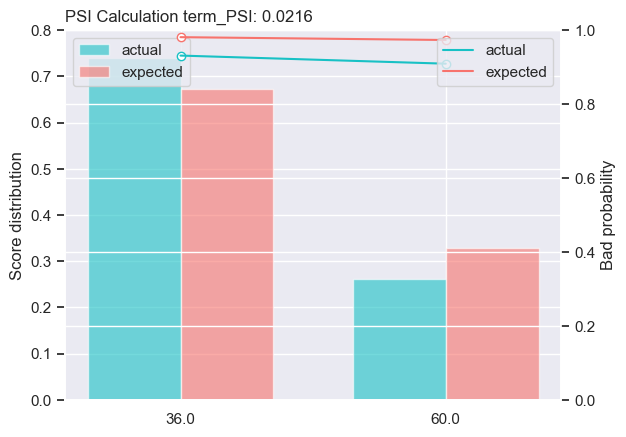

d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:502: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:471: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas.

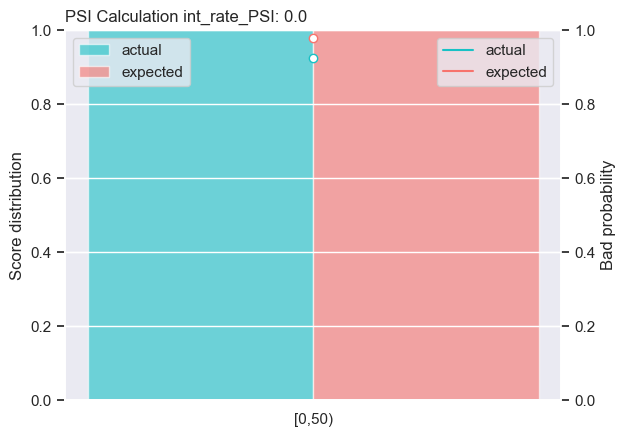

d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:502: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:471: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas.

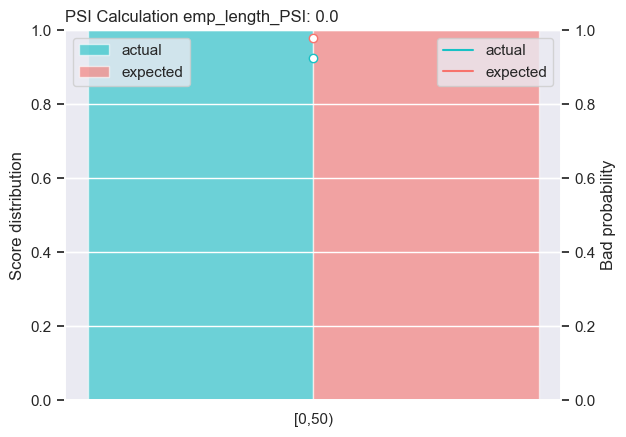

d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:502: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:471: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas.

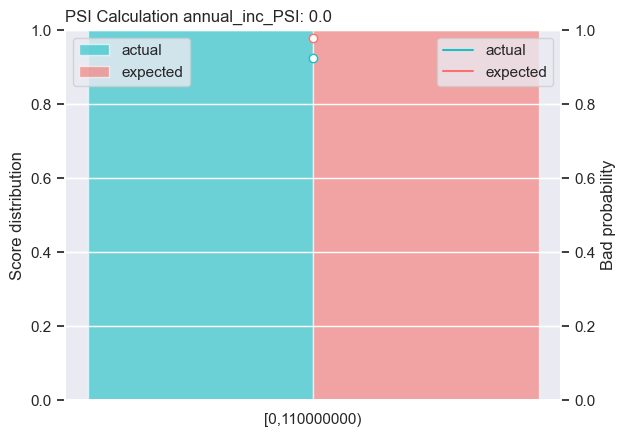

d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:502: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\credit_score\back\.venv\Lib\site-packages\scorecardpy\perf.py:471: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas.

Error occurred: single positional indexer is out-of-bounds


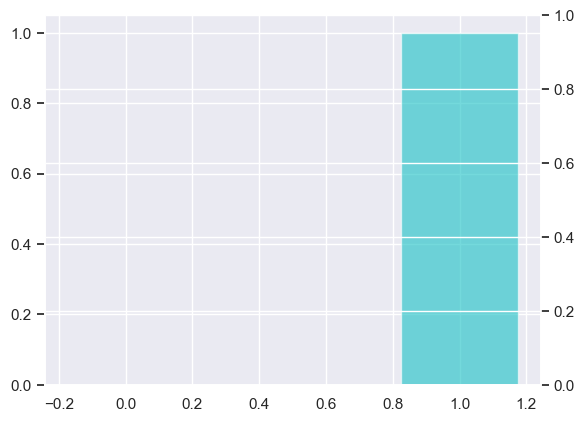

In [174]:
try:
    score = {
        "expected": data_org_cleaned,
        "actual": data_mo_cleaned
    }
    psi_result = sc.perf_psi(score=score, title="PSI Calculation")
    print(psi_result)
except Exception as e:
    print(f"Error occurred: {e}")


In [164]:
print(data_mo_cleaned.shape) 
print(data_org_cleaned.shape)

(759338, 18)
(336875, 18)


In [165]:
data_mo_cleaned.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['term', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths',
       'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d', 'y'],
      dtype='object')>

In [166]:
data_org_cleaned.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['term', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths',
       'revol_util', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d', 'y'],
      dtype='object')>

In [ ]:
data_org_cleaned = data_org.dropna()
data_mo_cleaned = data_mo.dropna()

data_org_cleaned = data_org_cleaned[['purpose', 'y']]
data_mo_cleaned = data_mo_cleaned[['purpose', 'y']]

In [ ]:
def calc_psi(expected, actual, bins, cat_var):
    expected_dist = expected[cat_var].value_counts(normalize=True).reindex(bins, fill_value=0)
    actual_dist = actual[cat_var].value_counts(normalize=True).reindex(bins, fill_value=0)
    
    psi = np.sum((expected_dist - actual_dist) * np.log((expected_dist / (actual_dist + 1e-10)) + 1e-10))
    return psi

# Danh sách các giá trị của biến categorical
bins = list(set(data_org['purpose']).union(set(data_mo['purpose'])))
psi_value = calc_psi(data_org, data_mo, bins, 'purpose')
print(psi_value)

0.026094721493252298


In [ ]:
cat_vars = ['grade', 'home_ownership', 'verification_status', 'purpose']
psi_list = []
for cat_var in cat_vars:
    psi = calc_psi(data_org, data_mo, bins, cat_var)
    psi_list.append(psi)

In [ ]:
psi_df = pd.DataFrame({
    'Variable': cat_vars,
    'PSI': psi_list
})

print(psi_df)

              Variable       PSI
0                grade  0.000000
1       home_ownership  0.000000
2  verification_status  0.000000
3              purpose  0.026095


In [ ]:
data_mo_cleaned.head()

,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,y
1,60,12.62,10.0,94000.0,25.61,0.0,105.8,14813.07,2060.09,873.16,360.95,234457.0,31900.0,338,38,32.0,32.0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,36,15.05,7.0,46350.0,8.88,0.0,44.9,5340.82,1032.46,348.28,209.01,121311.0,27700.0,218,38,32.0,32.0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,36,9.44,10.0,44000.0,27.06,1.0,18.7,17898.81,3237.80,736.61,652.91,62335.0,46900.0,163,38,32.0,32.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,36,11.99,10.0,85000.0,6.79,0.0,88.0,11460.66,2137.00,597.66,431.73,15332.0,7800.0,222,38,32.0,32.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,36,9.44,10.0,70000.0,18.34,0.0,58.2,10528.73,1904.57,433.30,384.06,211227.0,25800.0,276,38,32.0,32.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# predict on test set
y_hat_monitor = pipeline.predict(X_monitor)

# predicted probabilities of 1-class (good)
y_hat_monitor_proba = pipeline.predict_proba(X_test)[: ,1]

In [ ]:
accuracy = accuracy_score(y_monitor, y_hat_monitor)
precision = precision_score(y_monitor, y_hat_monitor)
recall = recall_score(y_monitor, y_hat_monitor)
f1 = f1_score(y_monitor, y_hat_monitor)
auc = roc_auc_score(y_monitor, y_hat_monitor)

# calculate Gini from AUROC
Gini = auc * 2 - 1
Gini

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {Gini:.2f}')

Accuracy: 0.74
Precision: 0.98
Recall: 0.74
F1-Score: 0.84
AUC: 0.75
Gini: 0.51


# Calculating credit scores

In [ ]:
X_train_woe_transformed.insert(0, 'Intercept', 1)

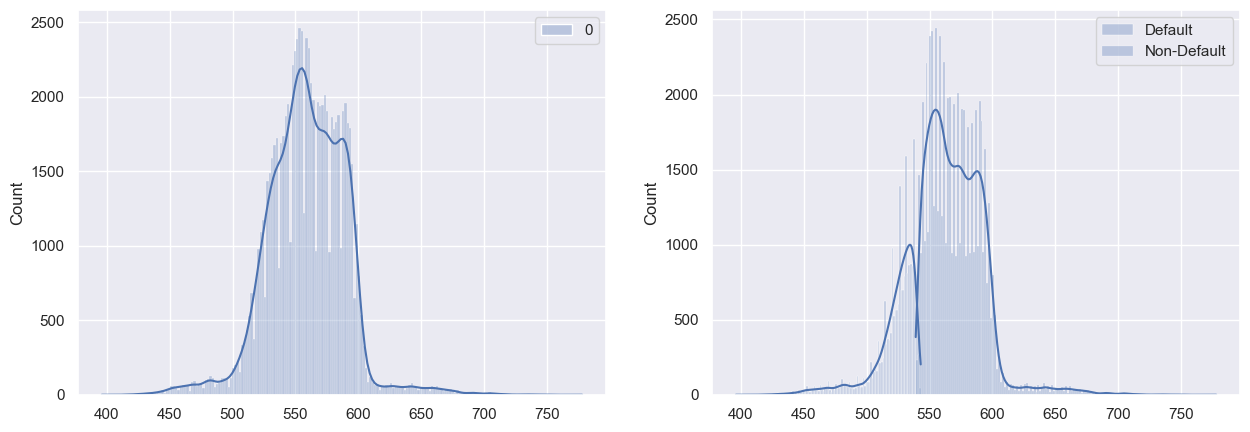

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(y_scores, kde=True, ax=axes[0], color='blue', alpha=0.3)

sns.histplot(y_scores[y_pred == 0], kde=True, ax=axes[1], color='blue', alpha=0.3, label='Default')
sns.histplot(y_scores[y_pred == 1], kde=True, ax=axes[1], color='green', alpha=0.3, label='Non-Default')

axes[1].legend()

plt.show()